# W&B Results Analysis

Pull experiment metrics from Weights & Biases, build comparison tables, and export LaTeX for the paper.

In [13]:
import os
from pathlib import Path

import wandb
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    sns = None
from dotenv import load_dotenv
from tqdm.auto import tqdm
import warnings

# Load .env from project root (parent of notebooks/)
load_dotenv(Path(__file__).resolve().parent.parent / ".env" if "__file__" in dir() else Path.cwd().parent / ".env")

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.width", 200)

api = wandb.Api()

/home/vlad.smirnov/miniconda3/envs/lm-polygraph-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from /home/vlad.smirnov/.netrc.


In [14]:
# ── Configuration ──────────────────────────────────────────────────────────────
#
# Organized by dataset -> strategy. Each group entry is a dict with:
#   "group_url":  link to the wandb group workspace
#   "runs":       list of {"seed": <int>, "run_url": "<url>"}
#
# Single-group strategies (baseline, self_consistency):
#   use a single dict wrapped in a list: [{"group_url": ..., "runs": [...]}]
#
# Multi-group strategies (offline_bon, beam_search, MUR — one group per scorer/aggregation/window):
#   use a list of dicts: [{"group_url": ..., "runs": [...]}, ...]
#
# Fill in the URLs. Entries with empty group_url or runs are skipped.

# ── MATH 500 ─────────────────────────────────────────────────────────────────

MATH500_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500/runs/qz0418nv"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500/runs/3bqhwvgp"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500/runs/bjzqimk4"},
        ],
    },
]

MATH500_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500/runs/ky44b84m"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500/runs/gtia4gii"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500/runs/v87vmndj"},
        ],
    },
]

MATH500_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer/runs/c35z6knc"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer/runs/d7jh7cbj"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer/runs/cz45vmb2"},
        ],
    },
]

MATH500_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_prm/workspace",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_prm/runs/5tafmoey?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_prm/runs/jhbjo8i7?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/runs/xwne3zcp?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/runs/i6h64mu9?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/runs/q4irrx7s?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/runs/j52otygf?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/runs/2jxse47c?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/runs/furt84c3?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/runs/p81rd7g2?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/runs/xzlye3bd?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/runs/1gqrkkbz?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/runs/3vyvg771?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/runs/a403svwj?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/runs/ym9gurc8?nw=nwuserkarantonis"},
        ],
    },
        # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
        # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

MATH500_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_mean/runs/a5czzn30?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/runs/ymsvscl0?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/runs/pwzb338g?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/runs/35flk5hs?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/runs/wyx5epvb?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/runs/6nvxalna?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/runs/cr02x91m?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/runs/sgz5baov?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/runs/3aal8hbt?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/runs/invmjf46?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/runs/t9izflf2?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/runs/jgwxu1tf?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/runs/1hib1872?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_min/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_min/runs/xsq5qs98?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
{
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/runs/s63imxgn?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/runs/lboffbb6?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/runs/3ty4qabr?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/runs/71lpyfud?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/runs/jdneto0g?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/runs/s704cw0h?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/runs/i0k09agh?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/runs/xk8esovp?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/runs/w8p45jwz?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/runs/9krm0sgu?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/runs/z0sfyacp?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/runs/rxvhmt25?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_RUNS = [
    *MATH500_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *MATH500_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *MATH500_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *MATH500_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

MATH500_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm/runs/vd5vmy7u"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm/runs/1a781e39"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm/runs/rj4rt3i2"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy/runs/tfztdzjl"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy/runs/ggqllnmy"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy/runs/aw88mzyl"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity/runs/r6oumz5s"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity/runs/4ds5ewag"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity/runs/5xe2x66l"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob/runs/j9a1j7mx"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob/runs/zcdc7nni"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob/runs/otrelz7z"},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_RUNS = [
    *MATH500_BASELINE_RUNS,
    *MATH500_SELF_CONSISTENCY_RUNS,
    *MATH500_OFFLINE_BON_RUNS,
    *MATH500_BEAM_SEARCH_RUNS,
    *MATH500_MUR_RUNS,
]

In [15]:
{
    "group_url": "",
    "runs": [
        {
            "seed": 42,
            "run_url": ""
        },
        {
            "seed": 43,
            "run_url": ""
        },
        {
            "seed": 44,
            "run_url": ""
        },
    ]
},

({'group_url': '',
  'runs': [{'seed': 42, 'run_url': ''},
   {'seed': 43, 'run_url': ''},
   {'seed': 44, 'run_url': ''}]},)

In [16]:
# ── Minerva Math ─────────────────────────────────────────────────────────────

MINERVA_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math/runs/96zj1bj9"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math/runs/uyw4bmip"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math/runs/qmm3t3wa"},
        ],
    },
]

MINERVA_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math/runs/pnfkhzub"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math/runs/puabpgai"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math/runs/697xpya5"},
        ],
    },
]

MINERVA_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/offline_bon_qwen25_math_7b_instruct_minerva_math_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/offline_bon_qwen25_math_7b_instruct_minerva_math_multi_scorer/runs/7syo0ks4"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/offline_bon_qwen25_math_7b_instruct_minerva_math_multi_scorer/runs/y6udmktu"},
            # TODO: seed 44
        ],
    },
]

MINERVA_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

MINERVA_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_RUNS = [
    *MINERVA_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *MINERVA_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *MINERVA_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *MINERVA_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

MINERVA_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm/runs/06l86wmp"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm/runs/rj3c55xp"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm/runs/mqxinev9"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy/runs/6x67bplt"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy/runs/9byp8if5"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy/runs/baw3autg"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity/runs/fdqevqae"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity/runs/v9d5f19e"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity/runs/1kotu42g"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/hhvycd8w"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/u9jsfizr"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/s1mch3ag"},
        ],
    },
]

MINERVA_RUNS = [
    *MINERVA_BASELINE_RUNS,
    *MINERVA_SELF_CONSISTENCY_RUNS,
    *MINERVA_OFFLINE_BON_RUNS,
    *MINERVA_BEAM_SEARCH_RUNS,
    *MINERVA_MUR_RUNS,
]

In [17]:
# ── Gaokao 2023 EN ──────────────────────────────────────────────────────────

GAOKAO_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en/runs/kv4jtvgi"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en/runs/oj4i6jcg"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en/runs/9jdwpyk5"},
        ],
    },
]

GAOKAO_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en/runs/fr4b84ia"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en/runs/cbuxlxty"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en/runs/66ny6wia"},
        ],
    },
]

GAOKAO_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer/runs/qijvr95c"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer/runs/jboxbdly"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer/runs/nh8fx6pk"},
        ],
    },
]

GAOKAO_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

GAOKAO_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_RUNS = [
    *GAOKAO_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *GAOKAO_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *GAOKAO_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *GAOKAO_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]


GAOKAO_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm/runs/s0fidl75"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm/runs/0ualpblk"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm/runs/32rg3g3i"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/hi6vme52"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/8803ke4z"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/2b58rqn2"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity",
        "runs": [
            # TODO: {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/t72yerk9"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/udabjan5"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/w39yrjlx"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/tg0re0ml"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/h8ceyznr"},
        ],
    },
]

GAOKAO_RUNS = [
    *GAOKAO_BASELINE_RUNS,
    *GAOKAO_SELF_CONSISTENCY_RUNS,
    *GAOKAO_OFFLINE_BON_RUNS,
    *GAOKAO_BEAM_SEARCH_RUNS,
    *GAOKAO_MUR_RUNS,
]

In [18]:
# ── OlympiadBench ────────────────────────────────────────────────────────────

OLYMPIAD_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench/runs/jzmy8hfc"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench/runs/xlys9l9j"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench/runs/b72k2bg3"},
        ],
    },
]

OLYMPIAD_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench/runs/fvfzlj30"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench/runs/ig5z868b"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench/runs/ivwtmfrj"},
        ],
    },
]

OLYMPIAD_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer/runs/scg2r5g6"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer/runs/lrbsr0b6"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer/runs/gzpylxq2"},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

OLYMPIAD_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_RUNS = [
    *OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *OLYMPIAD_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *OLYMPIAD_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

OLYMPIAD_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm/runs/i6z1krhj"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm/runs/6wvon0ez"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm/runs/tdm1eork"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy/runs/vd94h0mo"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy/runs/wf7xwmeq"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy/runs/mysyvdxk"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/v94x4z5v"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/j0wpb22k"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/ma4yye4m"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/9yrxl5jg"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/ux4lvczy"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/3i0vyyzt"},
        ],
    },
]

OLYMPIAD_RUNS = [
    *OLYMPIAD_BASELINE_RUNS,
    *OLYMPIAD_SELF_CONSISTENCY_RUNS,
    *OLYMPIAD_OFFLINE_BON_RUNS,
    *OLYMPIAD_BEAM_SEARCH_RUNS,
    *OLYMPIAD_MUR_RUNS,
]

In [19]:
# ── GPQA Diamond ─────────────────────────────────────────────────────────────

GPQA_BASELINE_RUNS = [
    {"group_url": "", "runs": []},
]

GPQA_EXTENDED_THINKING_RUNS = [
    {"group_url": "", "runs": []},
]

GPQA_SELF_CONSISTENCY_RUNS = [
    {"group_url": "", "runs": []},
]

GPQA_OFFLINE_BON_RUNS = []

GPQA_BEAM_SEARCH_RUNS = []

GPQA_RUNS = [
    *GPQA_BASELINE_RUNS,
    *GPQA_EXTENDED_THINKING_RUNS,
    *GPQA_SELF_CONSISTENCY_RUNS,
    *GPQA_OFFLINE_BON_RUNS,
    *GPQA_BEAM_SEARCH_RUNS,
]

In [20]:
# ── AIME 2024 ────────────────────────────────────────────────────────────────

AIME_24_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/xusm290p"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/rb5f45zd"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/ue7upatj"},
            {"seed": 45, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/2pxd5k62"},
            {"seed": 46, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/7wjepb0g"},
            {"seed": 47, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/mmvefyvq"},
        ],
    },
]

AIME_24_EXTENDED_THINKING_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024/runs/zpdp973a"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024/runs/toj7if32"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024/runs/nofu424d"},
        ],
    },
]

AIME_24_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024/runs/myd2mv7s"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024/runs/xffzht86"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024/runs/1pwqvj98"},
        ],
    },
]

AIME_24_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer/runs/b8ljb1q8"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer/runs/p3pcxz2f"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer/runs/my2dup72"},
        ],
    },
]

AIME_24_BEAM_SEARCH_RUNS = []

AIME_24_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm/runs/it11687o"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm/runs/jff7wjvc"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm/runs/lkq82tbw"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy/runs/0e8v1y8k"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy/runs/0ohmk93u"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy/runs/r3835jcu"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/runs/6akbzucw"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/runs/mqw6z61b"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/runs/27slpoyj"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob/runs/siootyv4"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob/runs/pbeoa8wj"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob/runs/ehlo2jyt"},
        ],
    },
]

AIME_24_RUNS = [
    *AIME_24_BASELINE_RUNS,
    *AIME_24_EXTENDED_THINKING_RUNS,
    *AIME_24_SELF_CONSISTENCY_RUNS,
    *AIME_24_OFFLINE_BON_RUNS,
    *AIME_24_BEAM_SEARCH_RUNS,
    *AIME_24_MUR_RUNS,
]

In [21]:
# ── AIME 2025 ────────────────────────────────────────────────────────────────

AIME_25_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/5z4xazfd"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/z8961dmg"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/vqkeqd8l"},
            {"seed": 45, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/8ng35cm8"},
            {"seed": 46, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/y6l7gl0x"},
            {"seed": 47, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/bvz1mgw4"},
        ],
    },
]

AIME_25_EXTENDED_THINKING_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025/runs/ynjskyb9"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025/runs/xw5oie56"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025/runs/uufgljky"},
        ],
    },
]

AIME_25_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/runs/e03jj1df"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/runs/4o5fp278"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/runs/yvpwgde3"},
        ],
    },
]

AIME_25_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer/runs/ja291w66"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer/runs/x7govl6j"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer/runs/qgbbh2v3"},
        ],
    },
]

AIME_25_BEAM_SEARCH_RUNS = []

AIME_25_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/runs/e42u6g0w"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/runs/3nne68cg"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/runs/upxrnkxo"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy/runs/d8m88x5o"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy/runs/hor6ahou"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy/runs/exlootac"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity/runs/3hsaelln"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity/runs/jertvzag"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity/runs/8o0wi4y3"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob/runs/tce8t6fy"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob/runs/krs5db1u"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob/runs/1ieu2i5k"},
        ],
    },
]

AIME_25_RUNS = [
    *AIME_25_BASELINE_RUNS,
    *AIME_25_EXTENDED_THINKING_RUNS,
    *AIME_25_SELF_CONSISTENCY_RUNS,
    *AIME_25_OFFLINE_BON_RUNS,
    *AIME_25_BEAM_SEARCH_RUNS,
    *AIME_25_MUR_RUNS,
]

In [22]:
# ── HumanEval-Plus ────────────────────────────────────────────────────────────

HUMANEVAL_BASELINE_RUNS = []

HUMANEVAL_EXTENDED_THINKING_RUNS = []

HUMANEVAL_SELF_CONSISTENCY_RUNS = []

HUMANEVAL_OFFLINE_BON_RUNS = []

HUMANEVAL_BEAM_SEARCH_RUNS = []

HUMANEVAL_MUR_RUNS = []

HUMANEVAL_RUNS = [
    *HUMANEVAL_BASELINE_RUNS,
    *HUMANEVAL_EXTENDED_THINKING_RUNS,
    *HUMANEVAL_SELF_CONSISTENCY_RUNS,
    *HUMANEVAL_OFFLINE_BON_RUNS,
    *HUMANEVAL_BEAM_SEARCH_RUNS,
    *HUMANEVAL_MUR_RUNS,
]


In [23]:
# ── All experiments ──────────────────────────────────────────────────────────

EXPERIMENT_RUNS = [
    *MATH500_RUNS,
    *MINERVA_RUNS,
    *GAOKAO_RUNS,
    *OLYMPIAD_RUNS,
    *GPQA_RUNS,
    *AIME_24_RUNS,
    *AIME_25_RUNS,
    *HUMANEVAL_RUNS,
]

# Which evaluator metric to use as the primary accuracy column
PRIMARY_EVALUATOR = "exact_match"  # or "llm_judge"

GROUP_FILTERS = None  # e.g. ["beam_search", "offline_bon"]

## Seed Coverage Tables

Quick overview of how many seeds (1/2/3) are registered for each (strategy, scorer, dataset) combination.

In [24]:
# ── Seed Coverage: Qwen2.5-Math-7B-Instruct (Non-Thinking) ─────────────────

import re as _re
from urllib.parse import urlparse as _urlparse


def _extract_scorer_from_group_url(url: str) -> str:
    """Extract scorer name from group URL (last segment after dataset name)."""
    path = _urlparse(url).path.strip("/")
    group = path.split("/")[-1]  # e.g. adaptive_scaling_qwen25_..._math500_prm
    for scorer in ["prm", "entropy", "perplexity", "sequence_prob", "uncertainty_pd", "multi_scorer"]:
        if group.endswith(f"_{scorer}"):
            return scorer
    return ""


def _count_seeds_with_url(run_list: list) -> tuple:
    """Count total seeds and return group URL. Returns (count, url)."""
    total = 0
    url = ""
    for entry in run_list:
        if entry.get("group_url"):
            total += len(entry.get("runs", []))
            if not url:
                url = entry["group_url"]
    return total, url


def _count_seeds_by_scorer_with_url(run_list: list) -> dict:
    """Count seeds per scorer with group URLs. Returns {scorer: (count, url)}."""
    result = {}
    for entry in run_list:
        if not entry.get("group_url"):
            continue
        scorer = _extract_scorer_from_group_url(entry["group_url"])
        result[scorer] = (len(entry.get("runs", [])), entry["group_url"])
    return result


def _color_cell(n_seeds, url=""):
    """Return styled HTML for seed count, optionally as a clickable link."""
    colors = {0: "#e74c3c", 1: "#e67e22", 2: "#f1c40f", 3: "#27ae60"}
    bg = {0: "#fdedec", 1: "#fdebd0", 2: "#fef9e7", 3: "#eafaf1"}
    style = (
        f'background:{bg.get(n_seeds, "#eee")};'
        f'padding:2px 8px;border-radius:3px;'
        f'color:{colors.get(n_seeds, "#333")};font-weight:bold'
    )
    if url:
        return (
            f'<a href="{url}" target="_blank" '
            f'style="{style};text-decoration:none">{n_seeds}</a>'
        )
    return f'<span style="{style}">{n_seeds}</span>'


def build_coverage_table(title, coverage_map, datasets, strategy_order, strategy_labels,
                         multi_scorer_strategies=None, scorer_list=None,
                         scorer_overrides=None):
    """Build an HTML coverage table with rowspan-merged strategy cells.

    Args:
        title: Table heading.
        coverage_map: {dataset: {strategy_key: run_list, ...}, ...}
        datasets: Column order for datasets.
        strategy_order: Row order for strategies.
        strategy_labels: {strategy_key: display_name}
        multi_scorer_strategies: Set of strategy keys that have per-scorer breakdowns.
        scorer_list: Ordered list of scorers for multi-scorer strategies.
    """
    if multi_scorer_strategies is None:
        multi_scorer_strategies = set()
    if scorer_list is None:
        scorer_list = ["prm", "entropy", "perplexity", "sequence_prob"]
    if scorer_overrides is None:
        scorer_overrides = {}

    # Build row specs: list of (strategy_label, scorer, {ds: (count, url)})
    row_specs = []
    for strat in strategy_order:
        label = strategy_labels.get(strat, strat)
        if strat in multi_scorer_strategies:
            for scorer in scorer_overrides.get(strat, scorer_list):
                cells = {}
                for ds in datasets:
                    by_scorer = _count_seeds_by_scorer_with_url(coverage_map[ds][strat])
                    cells[ds] = by_scorer.get(scorer, (0, ""))
                row_specs.append((label, scorer, cells))
        else:
            cells = {}
            for ds in datasets:
                cells[ds] = _count_seeds_with_url(coverage_map[ds][strat])
            row_specs.append((label, "", cells))

    # Compute rowspans per strategy group
    from collections import Counter
    strategy_counts = Counter(r[0] for r in row_specs)

    th = 'style="padding:6px 12px;border-bottom:2px solid #333;text-align:center"'
    html = f"<h3>{title}</h3>"
    html += '<table style="border-collapse:collapse;font-family:sans-serif;font-size:14px">'
    html += f"<tr><th {th}>Strategy</th><th {th}>Scorer</th>"
    for ds in datasets:
        html += f"<th {th}>{ds}</th>"
    html += "</tr>"

    seen_strategies = set()
    for label, scorer, cells in row_specs:
        first_in_group = label not in seen_strategies
        border = "border-top:1px solid #ccc;" if first_in_group and seen_strategies else ""
        html += f'<tr style="{border}">'

        # Strategy cell: rowspan on first row, skip on subsequent
        if first_in_group:
            rs = strategy_counts[label]
            va = "vertical-align:middle;" if rs > 1 else ""
            html += (
                f'<td rowspan="{rs}" style="padding:4px 12px;font-weight:bold;'
                f'{va}text-align:left">{label}</td>'
            )
            seen_strategies.add(label)

        # Scorer cell (left-aligned)
        scorer_display = scorer if scorer else "—"
        html += f'<td style="padding:4px 12px;text-align:left">{scorer_display}</td>'

        # Dataset cells
        for ds in datasets:
            n, url = cells[ds]
            html += f'<td style="padding:4px 12px;text-align:center">{_color_cell(n, url)}</td>'

        html += "</tr>"

    html += "</table>"
    return html


# ── Build Qwen2.5-Math-7B table ──
QWEN25_COVERAGE = {
    "MATH-500": {
        "baseline": MATH500_BASELINE_RUNS,
        "self_consistency": MATH500_SELF_CONSISTENCY_RUNS,
        "mur": MATH500_MUR_RUNS,
        "offline_bon": MATH500_OFFLINE_BON_RUNS,
    },
    "OlympiadBench": {
        "baseline": OLYMPIAD_BASELINE_RUNS,
        "self_consistency": OLYMPIAD_SELF_CONSISTENCY_RUNS,
        "mur": OLYMPIAD_MUR_RUNS,
        "offline_bon": OLYMPIAD_OFFLINE_BON_RUNS,
    },
    "Minerva Math": {
        "baseline": MINERVA_BASELINE_RUNS,
        "self_consistency": MINERVA_SELF_CONSISTENCY_RUNS,
        "mur": MINERVA_MUR_RUNS,
        "offline_bon": MINERVA_OFFLINE_BON_RUNS,
    },
    "Gaokao 2023 EN": {
        "baseline": GAOKAO_BASELINE_RUNS,
        "self_consistency": GAOKAO_SELF_CONSISTENCY_RUNS,
        "mur": GAOKAO_MUR_RUNS,
        "offline_bon": GAOKAO_OFFLINE_BON_RUNS,
    },
}

DATASETS_QWEN25 = ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"]

html = build_coverage_table(
    title="Qwen2.5-Math-7B-Instruct (Non-Thinking) \u2014 Seed Coverage",
    coverage_map=QWEN25_COVERAGE,
    datasets=DATASETS_QWEN25,
    strategy_order=["baseline", "self_consistency", "offline_bon", "mur"],
    strategy_labels={
        "baseline": "Raw CoT<br>(non-thinking)",
        "self_consistency": "Majority Voting<br>(self-consistency)",
        "offline_bon": "Offline BoN",
        "mur": "MUR"
    },
    multi_scorer_strategies={"mur", "offline_bon"},
    scorer_overrides={"offline_bon": ["multi_scorer"]},
)

from IPython.display import HTML
display(HTML(html))

# ── Seed Coverage: Qwen3-8B (Thinking Mode) ──────────────────────────────────

QWEN3_COVERAGE = {
    "AIME-2024": {
        "baseline": AIME_24_BASELINE_RUNS,
        "extended_thinking": AIME_24_EXTENDED_THINKING_RUNS,
        "self_consistency": AIME_24_SELF_CONSISTENCY_RUNS,
        "offline_bon": AIME_24_OFFLINE_BON_RUNS,
        "mur": AIME_24_MUR_RUNS,
    },
    "AIME-2025": {
        "baseline": AIME_25_BASELINE_RUNS,
        "extended_thinking": AIME_25_EXTENDED_THINKING_RUNS,
        "self_consistency": AIME_25_SELF_CONSISTENCY_RUNS,
        "offline_bon": AIME_25_OFFLINE_BON_RUNS,
        "mur": AIME_25_MUR_RUNS,
    },
    "HumanEval-Plus": {
        "baseline": HUMANEVAL_BASELINE_RUNS,
        "extended_thinking": HUMANEVAL_EXTENDED_THINKING_RUNS,
        "self_consistency": HUMANEVAL_SELF_CONSISTENCY_RUNS,
        "offline_bon": HUMANEVAL_OFFLINE_BON_RUNS,
        "mur": HUMANEVAL_MUR_RUNS,
    },
}

DATASETS_QWEN3 = ["AIME-2024", "AIME-2025", "HumanEval-Plus"]

html_qwen3 = build_coverage_table(
    title="Qwen3-8B (Thinking Mode) \u2014 Seed Coverage",
    coverage_map=QWEN3_COVERAGE,
    datasets=DATASETS_QWEN3,
    strategy_order=["baseline", "extended_thinking", "self_consistency", "offline_bon", "mur"],
    strategy_labels={
        "baseline": "Raw CoT<br>(thinking)",
        "extended_thinking": "Extended Thinking CoT",
        "self_consistency": "Majority Voting<br>(self-consistency)",
        "offline_bon": "Offline BoN",
        "mur": "MUR",
    },
    multi_scorer_strategies={"mur", "offline_bon"},
    scorer_overrides={"offline_bon": ["multi_scorer"]},
)

display(HTML(html_qwen3))


In [25]:
# ── Data Fetching ─────────────────────────────────────────────────────────────
import re
from urllib.parse import urlparse


def parse_group_url(url: str) -> dict:
    """Extract entity, project, and group name from a wandb group URL."""
    path = urlparse(url).path.strip("/")
    m = re.match(r"^(?P<entity>[^/]+)/(?P<project>[^/]+)/groups/(?P<group>[^/]+)", path)
    if not m:
        raise ValueError(f"Cannot parse group URL: {url}")
    return m.groupdict()


def parse_run_url(url: str) -> dict:
    """Extract entity, project, and run_id from a wandb run URL.

    Handles both formats:
      .../runs/RUN_ID
      .../groups/GROUP/runs/RUN_ID
    """
    path = urlparse(url).path.strip("/")
    m = re.match(r"^(?P<entity>[^/]+)/(?P<project>[^/]+)/(?:groups/[^/]+/)?runs/(?P<run_id>[^/]+)", path)
    if not m:
        raise ValueError(f"Cannot parse run URL: {url}")
    return m.groupdict()


def fetch_run(entity: str, project: str, run_id: str, group_name: str, seed: int) -> dict:
    """Fetch a single run and return a flat record dict."""
    run = api.run(f"{entity}/{project}/{run_id}")
    cfg = run.config
    s = run.summary._json_dict

    strategy_cfg = cfg.get("strategy", {})
    scorer_cfg = cfg.get("scorer", {})
    model_cfg = cfg.get("model", {})
    dataset_cfg = cfg.get("dataset", {})
    system_cfg = cfg.get("system", {})

    return {
        # identifiers
        "run_id": run.id,
        "run_name": run.name,
        "group": group_name,
        "state": run.state,
        "project": project,
        "entity": entity,
        "seed": seed,
        # config fields
        "strategy": strategy_cfg.get("type"),
        "scorer": scorer_cfg.get("type"),
        "aggregation": strategy_cfg.get("aggregation"),
        "scoring_window": strategy_cfg.get("scoring_window"),
        "scoring_window_label": strategy_cfg.get("scoring_window_label"),
        "model": model_cfg.get("model_short_name") or model_cfg.get("model_name"),
        "dataset": dataset_cfg.get("data_name"),
        "beam_size": strategy_cfg.get("beam_size"),
        "candidates_per_beam": strategy_cfg.get("candidates_per_beam"),
        "num_paths": strategy_cfg.get("num_paths"),
        "num_candidates": strategy_cfg.get("num_candidates"),
        "max_steps": strategy_cfg.get("max_steps"),
        # summary metrics
        "exact_match": s.get("exact_match/accuracy"),
        "llm_judge_accuracy": next(
            (v for k, v in s.items() if k.startswith("llm_judge") and k.endswith("/accuracy")),
            None,
        ),
        "avg_reasoning_steps": s.get("avg_reasoning_steps_per_trajectory"),
        "total_tokens": s.get("compute/total_tokens"),
        "total_input_tokens": s.get("compute/total_input_tokens"),
        "total_output_tokens": s.get("compute/total_output_tokens"),
        "total_tflops": s.get("compute/total_tflops"),
        "avg_tokens_per_sample": s.get("compute/avg_tokens_per_sample"),
        "avg_output_tokens_per_sample": s.get("compute/avg_output_tokens_per_sample"),
        "avg_tflops_per_sample": s.get("compute/avg_tflops_per_sample"),
        "total_generations": s.get("compute/total_generations"),
        "prm_tflops": s.get("compute/prm_tflops"),
        "total_samples": s.get("total_samples"),
        "completed": s.get("completed"),
    }


# Fetch all specified runs (skip entries with empty group_url or runs)
records = []
for entry in tqdm(EXPERIMENT_RUNS, desc="Fetching runs"):
    if not entry.get("group_url") or not entry.get("runs"):
        continue

    group_info = parse_group_url(entry["group_url"])
    group_name = group_info["group"]
    print(f"Group: {group_name}")

    for run_entry in entry["runs"]:
        seed = run_entry["seed"]
        run_info = parse_run_url(run_entry["run_url"])
        try:
            record = fetch_run(run_info["entity"], run_info["project"],
                               run_info["run_id"], group_name, seed)
            records.append(record)
            em = record.get("exact_match")
            llm = record.get("llm_judge_accuracy")
            if em is not None and llm is not None:
                diff = abs(em - llm)
                if diff > 0.10:
                    print(f"  ⚠ seed={seed}  {record['state']}  "
                          f"exact_match={em:.4f}  llm_judge={llm:.4f}  "
                          f"Δ={diff:.4f} — METRICS DIVERGE >10%")
                else:
                    print(f"  seed={seed}  {record['state']}  "
                          f"exact_match={em:.4f}  llm_judge={llm:.4f}")
            else:
                print(f"  seed={seed}  {record['state']}  "
                      f"exact_match={em}  llm_judge={llm}")
        except Exception as e:
            print(f"  ERROR fetching seed={seed}: {e}")

raw_df = pd.DataFrame(records)
print(f"\nTotal runs fetched: {len(raw_df)}")
raw_df.head()

Fetching runs:   0%|          | 0/124 [00:00<?, ?it/s]

Group: baseline_qwen25_math_7b_instruct_math500
  seed=42  finished  exact_match=0.8320  llm_judge=0.8380
  seed=43  finished  exact_match=0.8320  llm_judge=0.8380


Fetching runs:   1%|          | 1/124 [00:02<04:19,  2.11s/it]

  seed=44  finished  exact_match=0.8320  llm_judge=0.8400
Group: self_consistency_qwen25_math_7b_math500
  seed=42  finished  exact_match=0.8620  llm_judge=0.8660
  seed=43  finished  exact_match=0.8700  llm_judge=0.8740


Fetching runs:   2%|▏         | 2/124 [00:04<04:50,  2.38s/it]

  seed=44  finished  exact_match=0.8600  llm_judge=0.8660
Group: offline_bon_qwen25_math_7b_instruct_math500_multi_scorer
  seed=42  finished  exact_match=0.8500  llm_judge=0.8540
  seed=43  finished  exact_match=0.8540  llm_judge=0.8580


Fetching runs:   2%|▏         | 3/124 [00:09<06:03,  3.00s/it]

  seed=44  finished  exact_match=0.8340  llm_judge=0.8420
Group: offline_bon_qwen25_math_7b_instruct_math500_prm


ValueError: Cannot parse run URL: 

In [12]:
# ── Data Cleaning & Parsing ───────────────────────────────────────────────────

def parse_group_name(group: str | None) -> dict:
    """Best-effort extraction of structured fields from the group name.

    Expected patterns:
      {strategy}_{model}_{dataset}
      {strategy}_{model}_{dataset}_{scorer}
      {strategy}_{model}_{dataset}_{scorer}_{window}_{aggregation}
    """
    result = {"_group_strategy": None, "_group_model": None,
              "_group_dataset": None, "_group_scorer": None,
              "_group_window": None, "_group_aggregation": None}
    if not group:
        return result

    known_strategies = {
        "baseline", "chain_of_thought", "self_consistency",
        "online_bon", "offline_bon", "beam_search",
        "uncertainty_cot", "extended_thinking",
        "adaptive_scaling", "deepconf",
    }
    known_scorers = {
        "prm", "entropy", "perplexity", "sequence_prob",
        "uncertainty", "uncertainty_pd", "uncertainty_uhead",
    }
    known_aggregations = {"mean", "min", "max", "sum", "product", "median"}
    known_datasets = {
        "minerva_math", "math500", "aime2024", "aime2025",
        "gaokao2023en", "human_eval_plus", "olympiadbench",
    }

    parts = group.split("_")

    # Greedy match strategy prefix (try longest first)
    strategy = None
    for length in range(min(3, len(parts)), 0, -1):
        candidate = "_".join(parts[:length])
        if candidate in known_strategies:
            strategy = candidate
            parts = parts[length:]
            break
    result["_group_strategy"] = strategy

    # Scan remaining parts for known tokens
    remaining = "_".join(parts)
    for ds in sorted(known_datasets, key=len, reverse=True):
        if ds in remaining:
            result["_group_dataset"] = ds
            remaining = remaining.replace(ds, "", 1)
            break
    for sc in sorted(known_scorers, key=len, reverse=True):
        if f"_{sc}" in f"_{remaining}":
            result["_group_scorer"] = sc
            remaining = remaining.replace(sc, "", 1)
            break
    for ag in known_aggregations:
        if f"_{ag}" in f"_{remaining}":
            result["_group_aggregation"] = ag
            break
    # window: look for a bare integer or "all"
    for p in remaining.split("_"):
        if p.isdigit():
            result["_group_window"] = p
            break
        if p == "all":
            result["_group_window"] = "all"
            break

    # model: whatever remains after removing known tokens is likely the model
    for tok in [result["_group_dataset"], result["_group_scorer"],
                result["_group_aggregation"], result["_group_window"]]:
        if tok:
            remaining = remaining.replace(tok, "", 1)
    model_str = "_".join(p for p in remaining.split("_") if p)
    result["_group_model"] = model_str or None

    return result


df = raw_df.copy()

# Parse group names to fill missing config columns
parsed = df["group"].apply(parse_group_name).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)

# Fill missing config from parsed group name
for col, gcol in [("strategy", "_group_strategy"), ("scorer", "_group_scorer"),
                   ("aggregation", "_group_aggregation"),
                   ("scoring_window", "_group_window"),
                   ("dataset", "_group_dataset"), ("model", "_group_model")]:
    df[col] = df[col].fillna(df[gcol])

# Drop helper columns
df.drop(columns=[c for c in df.columns if c.startswith("_group_")], inplace=True)

# Filter to finished runs only
n_before = len(df)
df = df[df["state"] == "finished"].copy()
print(f"Kept {len(df)}/{n_before} finished runs")

# Optional group filter
if GROUP_FILTERS:
    mask = df["group"].apply(lambda g: any(f in (g or "") for f in GROUP_FILTERS))
    df = df[mask].copy()
    print(f"After group filter: {len(df)} runs")

# Create human-readable project label from wandb project name
PROJECT_LABEL_MAP = {
    "llm-tts-eval-math500": "MATH-500",
    "llm-tts-eval-minerva-math": "Minerva Math",
    "llm-tts-eval-minerva_math": "Minerva Math",
    "llm-tts-eval-gaokao2023en": "Gaokao 2023 EN",
    "llm-tts-eval-olympiadbench": "OlympiadBench",
    "llm-tts-eval-gpqa-diamond": "GPQA Diamond",
    "llm-tts-eval-gpqa_diamond": "GPQA Diamond",
    "llm-tts-eval-aime24": "AIME 2024",
    "llm-tts-eval-aime2024": "AIME 2024",
    "llm-tts-eval-aime25": "AIME 2025",
    "llm-tts-eval-aime2025": "AIME 2025",
}
df["project_label"] = df["project"].map(PROJECT_LABEL_MAP).fillna(df["project"])

# Normalize accuracy to percentage
for col in ["exact_match", "llm_judge_accuracy"]:
    if col in df.columns:
        # If values look like fractions (0-1), convert to pct
        mask = df[col].notna() & (df[col] <= 1.0)
        df.loc[mask, col] = df.loc[mask, col] * 100

print(f"\nStrategies: {sorted(df['strategy'].dropna().unique())}")
print(f"Scorers:    {sorted(df['scorer'].dropna().unique())}")
print(f"Datasets:   {sorted(df['project_label'].dropna().unique())}")
df[["strategy", "scorer", "aggregation", "scoring_window", "project_label", "dataset", "model",
    "exact_match", "total_tflops"]].head(10)

Kept 136/136 finished runs

Strategies: ['adaptive', 'baseline', 'extended_thinking', 'offline_best_of_n', 'self_consistency']
Scorers:    ['entropy', 'perplexity', 'prm', 'sequence_prob']
Datasets:   ['AIME 2024', 'AIME 2025', 'Gaokao 2023 EN', 'MATH-500', 'Minerva Math', 'OlympiadBench']


,strategy,scorer,aggregation,scoring_window,project_label,dataset,model,exact_match,total_tflops
0,baseline,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,83.2,5133.156
1,baseline,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,83.2,5133.156
2,baseline,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,83.2,5133.156
3,self_consistency,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,86.2,35634.144
4,self_consistency,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,87.0,35760.256
5,self_consistency,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,86.0,35646.268
6,offline_best_of_n,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,85.0,37234.708
7,offline_best_of_n,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,85.4,37780.848
8,offline_best_of_n,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,83.4,37954.980
9,adaptive,prm,None,None,MATH-500,math,qwen25_math_7b_instruct,83.6,170584.442


In [13]:
# ── Seed Averaging ────────────────────────────────────────────────────────────

CONFIG_COLS = ["strategy", "scorer", "aggregation", "scoring_window",
               "model", "dataset", "project_label",
               "beam_size", "candidates_per_beam", "num_paths", "num_candidates"]

METRIC_COLS = ["exact_match", "llm_judge_accuracy", "avg_reasoning_steps",
               "total_tokens", "total_tflops", "avg_tokens_per_sample",
               "avg_output_tokens_per_sample", "avg_tflops_per_sample"]


def aggregate_seeds(df: pd.DataFrame) -> pd.DataFrame:
    """Group by config columns and compute mean/std over seeds."""
    present_cfg = [c for c in CONFIG_COLS if c in df.columns]
    present_met = [c for c in METRIC_COLS if c in df.columns]

    grouped = df.groupby(present_cfg, dropna=False)
    agg = grouped[present_met].agg(["mean", "std", "count"]).reset_index()

    # Flatten multi-level columns
    flat_cols = []
    for col in agg.columns:
        if isinstance(col, tuple) and col[1]:
            flat_cols.append(f"{col[0]}_{col[1]}")
        else:
            flat_cols.append(col[0] if isinstance(col, tuple) else col)
    agg.columns = flat_cols

    # Add a formatted "mean +/- std" column for the primary metric
    for m in present_met:
        mean_col, std_col = f"{m}_mean", f"{m}_std"
        if mean_col in agg.columns:
            agg[f"{m}_fmt"] = agg.apply(
                lambda r: f"{r[mean_col]:.1f} +/- {r[std_col]:.1f}"
                if pd.notna(r[std_col]) and r.get(f"{m}_count", 0) > 1
                else (f"{r[mean_col]:.1f}" if pd.notna(r[mean_col]) else ""),
                axis=1,
            )
    return agg


agg_df = aggregate_seeds(df)
print(f"Aggregated configs: {len(agg_df)}")
agg_df.head()

Aggregated configs: 44


,strategy,scorer,aggregation,scoring_window,model,dataset,project_label,beam_size,candidates_per_beam,num_paths,num_candidates,exact_match_mean,exact_match_std,exact_match_count,llm_judge_accuracy_mean,llm_judge_accuracy_std,llm_judge_accuracy_count,avg_reasoning_steps_mean,avg_reasoning_steps_std,avg_reasoning_steps_count,total_tokens_mean,total_tokens_std,total_tokens_count,total_tflops_mean,total_tflops_std,total_tflops_count,avg_tokens_per_sample_mean,avg_tokens_per_sample_std,avg_tokens_per_sample_count,avg_output_tokens_per_sample_mean,avg_output_tokens_per_sample_std,avg_output_tokens_per_sample_count,avg_tflops_per_sample_mean,avg_tflops_per_sample_std,avg_tflops_per_sample_count,exact_match_fmt,llm_judge_accuracy_fmt,avg_reasoning_steps_fmt,total_tokens_fmt,total_tflops_fmt,avg_tokens_per_sample_fmt,avg_output_tokens_per_sample_fmt,avg_tflops_per_sample_fmt
0,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,gaokao2023en,Gaokao 2023 EN,NaN,NaN,NaN,NaN,68.398268,0.912178,3,72.900433,1.227485,3,6.079654,0.058677,3,2.833733e+06,7.604322e+04,3,39672.257333,1064.605083,3,7360.344589,197.514858,3,4039.057143,183.845981,3,103.044824,2.765208,3,68.4 +/- 0.9,72.9 +/- 1.2,6.1 +/- 0.1,2833732.7 +/- 76043.2,39672.3 +/- 1064.6,7360.3 +/- 197.5,4039.1 +/- 183.8,103.0 +/- 2.8
1,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,math,MATH-500,NaN,NaN,NaN,NaN,84.000000,0.529150,3,84.533333,0.642910,3,6.054667,0.117377,3,3.527878e+06,1.084599e+05,3,49390.292000,1518.438853,3,7055.756000,216.919836,3,3910.163333,81.139192,3,98.780584,3.036878,3,84.0 +/- 0.5,84.5 +/- 0.6,6.1 +/- 0.1,3527878.0 +/- 108459.9,49390.3 +/- 1518.4,7055.8 +/- 216.9,3910.2 +/- 81.1,98.8 +/- 3.0
2,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,minerva_math,Minerva Math,NaN,NaN,NaN,NaN,39.460784,2.582268,3,45.098039,2.502522,3,6.133578,0.161695,3,1.726833e+06,7.008064e+04,3,24175.666667,981.128893,3,6348.651961,257.649394,3,2792.047794,80.581655,3,88.881127,3.607092,3,39.5 +/- 2.6,45.1 +/- 2.5,6.1 +/- 0.2,1726833.3 +/- 70080.6,24175.7 +/- 981.1,6348.7 +/- 257.6,2792.0 +/- 80.6,88.9 +/- 3.6
3,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,olympiadbench,OlympiadBench,NaN,NaN,NaN,NaN,40.246914,0.905200,3,43.753086,0.986419,3,7.374815,0.046069,3,6.541236e+06,1.045451e+05,3,91577.308667,1463.631096,3,9690.720494,154.881597,3,4365.265185,94.415847,3,135.670087,2.168342,3,40.2 +/- 0.9,43.8 +/- 1.0,7.4 +/- 0.0,6541236.3 +/- 104545.1,91577.3 +/- 1463.6,9690.7 +/- 154.9,4365.3 +/- 94.4,135.7 +/- 2.2
4,adaptive,entropy,NaN,NaN,vllm_thinking_qwen3_8b,aime24,AIME 2024,NaN,NaN,NaN,NaN,74.444444,3.849002,3,74.444444,3.849002,3,68.133333,6.490249,3,1.959623e+07,2.825310e+06,3,313539.680000,45204.958464,3,653207.666667,94176.996801,3,38269.611111,1813.174750,3,10451.322667,1506.831949,3,74.4 +/- 3.8,74.4 +/- 3.8,68.1 +/- 6.5,19596230.0 +/- 2825309.9,313539.7 +/- 45205.0,653207.7 +/- 94177.0,38269.6 +/- 1813.2,10451.3 +/- 1506.8


In [14]:
# ── Pivot Table Helper ────────────────────────────────────────────────────────

def make_comparison_table(
    df: pd.DataFrame,
    row_field: str,
    col_field: str,
    value_field: str = "exact_match_fmt",
    filter_dict: dict | None = None,
    title: str | None = None,
) -> pd.DataFrame:
    """Build a pivot table from the aggregated DataFrame."""
    sub = df.copy()
    if filter_dict:
        for k, v in filter_dict.items():
            if isinstance(v, list):
                sub = sub[sub[k].isin(v)]
            else:
                sub = sub[sub[k] == v]

    if sub.empty:
        print("No data after filtering.")
        return pd.DataFrame()

    pivot = sub.pivot_table(
        index=row_field,
        columns=col_field,
        values=value_field,
        aggfunc="first",
    )
    if title:
        print(f"\n{'=' * len(title)}")
        print(title)
        print(f"{'=' * len(title)}")
    return pivot

In [15]:
# ── Table 1: Strategy x Scorer Grid ───────────────────────────────────────────

for dataset_label in sorted(agg_df["project_label"].dropna().unique()):
    tbl = make_comparison_table(
        agg_df,
        row_field="scorer",
        col_field="strategy",
        value_field="exact_match_fmt",
        filter_dict={"project_label": dataset_label},
        title=f"Exact Match (%) — {dataset_label}",
    )
    if not tbl.empty:
        display(tbl)


Exact Match (%) — AIME 2024


strategy,adaptive,baseline,extended_thinking,offline_best_of_n,self_consistency
scorer,,,,,
entropy,74.4 +/- 3.8,75.6 +/- 2.7,78.9 +/- 5.1,75.6 +/- 5.1,82.2 +/- 1.9
perplexity,76.7 +/- 0.0,NaN,NaN,NaN,NaN
prm,77.8 +/- 3.8,NaN,NaN,NaN,NaN
sequence_prob,76.7 +/- 3.3,NaN,NaN,NaN,NaN



Exact Match (%) — AIME 2025


strategy,adaptive,baseline,extended_thinking,offline_best_of_n,self_consistency
scorer,,,,,
entropy,65.6 +/- 5.1,64.4 +/- 6.2,66.7 +/- 3.3,64.4 +/- 5.1,34.4 +/- 6.9
perplexity,68.9 +/- 5.1,NaN,NaN,NaN,NaN
prm,67.8 +/- 5.1,NaN,NaN,NaN,NaN
sequence_prob,70.0 +/- 5.8,NaN,NaN,NaN,NaN



Exact Match (%) — Gaokao 2023 EN


strategy,adaptive,baseline,offline_best_of_n,self_consistency
scorer,,,,
entropy,68.4 +/- 0.9,68.6 +/- 0.0,68.9 +/- 0.3,72.4 +/- 1.2
perplexity,69.0 +/- 0.9,NaN,NaN,NaN
prm,70.6 +/- 0.8,NaN,NaN,NaN
sequence_prob,68.8 +/- 1.6,NaN,NaN,NaN



Exact Match (%) — MATH-500


strategy,adaptive,baseline,offline_best_of_n,self_consistency
scorer,,,,
entropy,84.0 +/- 0.5,83.2 +/- 0.0,84.6 +/- 1.1,86.4 +/- 0.5
perplexity,84.5 +/- 0.1,NaN,NaN,NaN
prm,84.0 +/- 0.5,NaN,NaN,NaN
sequence_prob,83.6 +/- 0.5,NaN,NaN,NaN



Exact Match (%) — Minerva Math


strategy,adaptive,baseline,offline_best_of_n,self_consistency
scorer,,,,
entropy,39.5 +/- 2.6,42.3 +/- 0.0,40.4 +/- 0.0,44.5 +/- 0.7
perplexity,40.2 +/- 0.8,NaN,NaN,NaN
prm,40.8 +/- 1.3,NaN,NaN,NaN
sequence_prob,40.1 +/- 1.9,NaN,NaN,NaN



Exact Match (%) — OlympiadBench


strategy,adaptive,baseline,offline_best_of_n,self_consistency
scorer,,,,
entropy,40.2 +/- 0.9,39.3 +/- 0.0,40.1 +/- 1.0,44.7 +/- 0.6
perplexity,40.3 +/- 1.5,NaN,NaN,NaN
prm,42.7 +/- 0.7,NaN,NaN,NaN
sequence_prob,40.4 +/- 1.1,NaN,NaN,NaN


In [16]:
# ── Table 2: Aggregation x Scoring Window (beam search only) ──────────────────

beam_df = agg_df[agg_df["strategy"] == "beam_search"].copy()

if beam_df.empty:
    print("No beam search runs found.")
else:
    for scorer in sorted(beam_df["scorer"].dropna().unique()):
        for dataset_label in sorted(beam_df["project_label"].dropna().unique()):
            tbl = make_comparison_table(
                beam_df,
                row_field="aggregation",
                col_field="scoring_window",
                value_field="exact_match_fmt",
                filter_dict={"scorer": scorer, "project_label": dataset_label},
                title=f"Beam Search — scorer={scorer}, dataset={dataset_label}",
            )
            if not tbl.empty:
                display(tbl)

No beam search runs found.


In [17]:
# ── Table 3: Compute Efficiency ───────────────────────────────────────────────

eff_cols = ["strategy", "scorer", "aggregation", "scoring_window",
            "project_label", "model",
            "exact_match_mean", "total_tflops_mean",
            "avg_tokens_per_sample_mean", "avg_reasoning_steps_mean"]
present = [c for c in eff_cols if c in agg_df.columns]
eff_df = agg_df[present].copy()

# Rename for readability
rename_map = {
    "exact_match_mean": "Accuracy (%)",
    "total_tflops_mean": "Total TFLOPS",
    "avg_tokens_per_sample_mean": "Tokens/Problem",
    "avg_reasoning_steps_mean": "Reasoning Steps",
}
eff_df.rename(columns={k: v for k, v in rename_map.items() if k in eff_df.columns},
              inplace=True)

eff_df.sort_values("Accuracy (%)", ascending=False, inplace=True)
print("Compute Efficiency Overview")
print("=" * 40)
display(eff_df.reset_index(drop=True))

Compute Efficiency Overview


,strategy,scorer,aggregation,scoring_window,project_label,model,Accuracy (%),Total TFLOPS,Tokens/Problem,Reasoning Steps
0,self_consistency,entropy,NaN,NaN,MATH-500,qwen25_math_7b_instruct,86.400000,3.568022e+04,5097.174667,1.000000
1,offline_best_of_n,entropy,NaN,NaN,MATH-500,qwen25_math_7b_instruct,84.600000,3.765685e+04,5379.549333,3.580667
2,adaptive,perplexity,NaN,NaN,MATH-500,qwen25_math_7b_instruct,84.533333,5.240861e+04,7486.944667,6.204000
3,adaptive,entropy,NaN,NaN,MATH-500,qwen25_math_7b_instruct,84.000000,4.939029e+04,7055.756000,6.054667
4,adaptive,prm,NaN,NaN,MATH-500,qwen25_math_7b_instruct,84.000000,1.695278e+05,9074.406667,6.216000
5,adaptive,sequence_prob,NaN,NaN,MATH-500,qwen25_math_7b_instruct,83.600000,5.488382e+04,7840.545333,6.334667
6,baseline,entropy,NaN,NaN,MATH-500,qwen25_math_7b_instruct,83.200000,5.133156e+03,733.308000,1.000000
7,self_consistency,entropy,NaN,NaN,AIME 2024,vllm_thinking_qwen3_8b,82.222222,5.279722e+04,109994.211111,0.765278
8,extended_thinking,entropy,NaN,NaN,AIME 2024,vllm_thinking_qwen3_8b,78.888889,2.647765e+04,55161.777778,NaN
9,adaptive,prm,NaN,NaN,AIME 2024,vllm_thinking_qwen3_8b,77.777778,1.446222e+06,954790.988889,80.888889


In [18]:
# ── LaTeX Export ──────────────────────────────────────────────────────────────

def to_latex(df: pd.DataFrame, caption: str, label: str) -> str:
    """Convert a DataFrame to a booktabs LaTeX table string."""
    latex = df.to_latex(
        index=True,
        escape=True,
        na_rep="--",
        caption=caption,
        label=label,
        position="htbp",
    )
    # Add booktabs rules
    latex = latex.replace("\\toprule", "\\toprule")  # already there with booktabs
    return latex


# Re-generate tables and export as LaTeX
latex_outputs = []

# Strategy x Scorer tables
for dataset_label in sorted(agg_df["project_label"].dropna().unique()):
    tbl = make_comparison_table(
        agg_df,
        row_field="scorer",
        col_field="strategy",
        value_field="exact_match_fmt",
        filter_dict={"project_label": dataset_label},
    )
    if not tbl.empty:
        ltx = to_latex(
            tbl,
            caption=f"Exact match accuracy (\\%) by strategy and scorer on {dataset_label}.",
            label=f"tab:strategy_scorer_{dataset_label}",
        )
        latex_outputs.append((f"Strategy x Scorer — {dataset_label}", ltx))

# Beam search aggregation x window tables
if not beam_df.empty:
    for scorer in sorted(beam_df["scorer"].dropna().unique()):
        for dataset_label in sorted(beam_df["project_label"].dropna().unique()):
            tbl = make_comparison_table(
                beam_df,
                row_field="aggregation",
                col_field="scoring_window",
                value_field="exact_match_fmt",
                filter_dict={"scorer": scorer, "project_label": dataset_label},
            )
            if not tbl.empty:
                ltx = to_latex(
                    tbl,
                    caption=f"Beam search accuracy (\\%) — scorer={scorer}, dataset={dataset_label}.",
                    label=f"tab:beam_{scorer}_{dataset_label}",
                )
                latex_outputs.append((f"Beam {scorer} — {dataset_label}", ltx))

# Efficiency table
if not eff_df.empty:
    ltx = to_latex(
        eff_df.reset_index(drop=True),
        caption="Compute efficiency comparison across strategies.",
        label="tab:compute_efficiency",
    )
    latex_outputs.append(("Compute Efficiency", ltx))

# Print all LaTeX
for title, ltx in latex_outputs:
    print(f"% ── {title} " + "─" * (60 - len(title)))
    print(ltx)
    print()

% ── Strategy x Scorer — AIME 2024 ───────────────────────────────
\begin{table}[htbp]
\caption{Exact match accuracy (\%) by strategy and scorer on AIME 2024.}
\label{tab:strategy_scorer_AIME 2024}
\begin{tabular}{llllll}
\toprule
strategy & adaptive & baseline & extended\_thinking & offline\_best\_of\_n & self\_consistency \\
scorer &  &  &  &  &  \\
\midrule
entropy & 74.4 +/- 3.8 & 75.6 +/- 2.7 & 78.9 +/- 5.1 & 75.6 +/- 5.1 & 82.2 +/- 1.9 \\
perplexity & 76.7 +/- 0.0 & -- & -- & -- & -- \\
prm & 77.8 +/- 3.8 & -- & -- & -- & -- \\
sequence\_prob & 76.7 +/- 3.3 & -- & -- & -- & -- \\
\bottomrule
\end{tabular}
\end{table}


% ── Strategy x Scorer — AIME 2025 ───────────────────────────────
\begin{table}[htbp]
\caption{Exact match accuracy (\%) by strategy and scorer on AIME 2025.}
\label{tab:strategy_scorer_AIME 2025}
\begin{tabular}{llllll}
\toprule
strategy & adaptive & baseline & extended\_thinking & offline\_best\_of\_n & self\_consistency \\
scorer &  &  &  &  &  \\
\midrule
entr

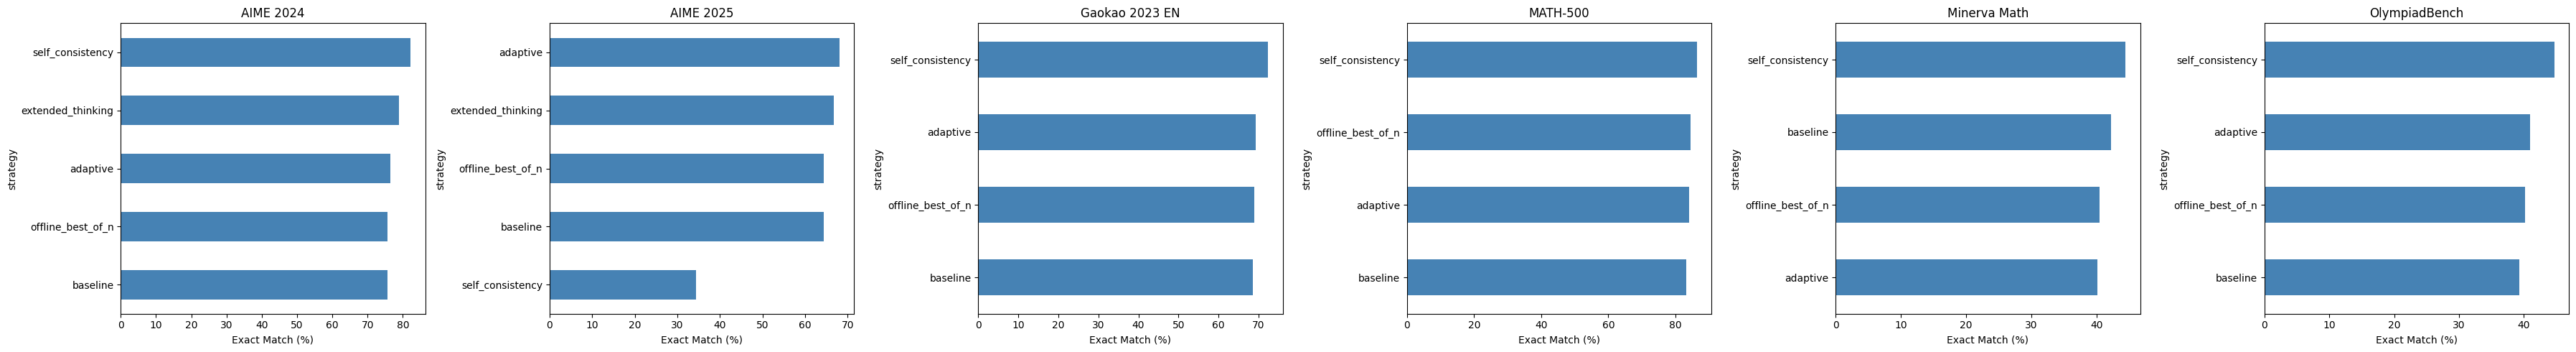

In [19]:
# ── Visualization ─────────────────────────────────────────────────────────────

# Bar chart: accuracy by strategy (per dataset)
plot_df = agg_df.dropna(subset=["exact_match_mean"]).copy()

if not plot_df.empty:
    fig, axes = plt.subplots(
        1, max(1, plot_df["project_label"].nunique()),
        figsize=(6 * max(1, plot_df["project_label"].nunique()), 5),
        squeeze=False,
    )
    for idx, dataset_label in enumerate(sorted(plot_df["project_label"].unique())):
        ax = axes[0, idx]
        sub = plot_df[plot_df["project_label"] == dataset_label]
        # Average across scorers/configs per strategy
        bars = sub.groupby("strategy")["exact_match_mean"].mean().sort_values()
        bars.plot.barh(ax=ax, color="steelblue")
        ax.set_xlabel("Exact Match (%)")
        ax.set_title(dataset_label)
    plt.tight_layout()
    plt.show()
else:
    print("No data for bar chart.")

In [20]:
# Heatmap: beam search scorer x aggregation x window

if sns is None:
    print("Install seaborn for heatmap visualization: pip install seaborn")
elif not beam_df.empty:
    heat_df = beam_df.dropna(subset=["exact_match_mean"]).copy()
    heat_df["config"] = heat_df["aggregation"].astype(str) + " / w=" + heat_df["scoring_window"].astype(str)

    for dataset_label in sorted(heat_df["project_label"].dropna().unique()):
        sub = heat_df[heat_df["project_label"] == dataset_label]
        if sub.empty:
            continue
        pivot = sub.pivot_table(
            index="config", columns="scorer",
            values="exact_match_mean", aggfunc="first",
        )
        if pivot.empty:
            continue

        fig, ax = plt.subplots(figsize=(max(6, pivot.shape[1] * 2), max(4, pivot.shape[0] * 0.6)))
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax)
        ax.set_title(f"Beam Search Accuracy — {dataset_label}")
        plt.tight_layout()
        plt.show()
else:
    print("No beam search data for heatmap.")

Install seaborn for heatmap visualization: pip install seaborn


## Offline BoN Multi-Scorer Analysis

Download `candidates.json` from multi-scorer offline BoN runs and re-analyze
with different scorers, aggregation methods, and scoring windows.

In [21]:
import sys
import json as _json
from pathlib import Path as _Path

# Add project root and scripts/ to path so we can import analyze_candidates
_project_root = _Path.cwd().parent if _Path.cwd().name == "notebooks" else _Path.cwd()
for _p in [str(_project_root), str(_project_root / "scripts")]:
    if _p not in sys.path:
        sys.path.insert(0, _p)

from analyze_candidates import (
    aggregate_scores,
    select_best_candidate,
    precompute_correctness,
    analyze,
    analyze_all_windows,
    _save_csv,
)

print("Imported analyze_candidates functions")

ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
Imported analyze_candidates functions


In [22]:
# ── Offline BoN Registry ──────────────────────────────────────────────────────
# Maps run lists → (data_name, answer_format, display_label) for candidates.json analysis.

OFFLINE_BON_REGISTRY = [
    (MATH500_OFFLINE_BON_RUNS, "math500", "numeric", "MATH-500"),
    (MINERVA_OFFLINE_BON_RUNS, "minerva_math", "numeric", "Minerva Math"),
    (GAOKAO_OFFLINE_BON_RUNS, "gaokao2023en", "numeric", "Gaokao 2023 EN"),
    (OLYMPIAD_OFFLINE_BON_RUNS, "olympiadbench", "numeric", "OlympiadBench"),
    (AIME_24_OFFLINE_BON_RUNS, "aime2024", "numeric", "AIME 2024"),
    (AIME_25_OFFLINE_BON_RUNS, "aime2025", "numeric", "AIME 2025"),
    # (GPQA_OFFLINE_BON_RUNS, "gpqa_diamond", "char", "GPQA Diamond"),
]

print(f"Registry: {len(OFFLINE_BON_REGISTRY)} dataset(s)")
for run_list, dname, fmt, label in OFFLINE_BON_REGISTRY:
    n_runs = sum(len(e.get("runs", [])) for e in run_list if e.get("group_url"))
    print(f"  {label}: {n_runs} run(s)")

Registry: 6 dataset(s)
  MATH-500: 3 run(s)
  Minerva Math: 2 run(s)
  Gaokao 2023 EN: 3 run(s)
  OlympiadBench: 3 run(s)
  AIME 2024: 3 run(s)
  AIME 2025: 3 run(s)


In [23]:
# ── Download candidates.json from wandb ───────────────────────────────────────

import tempfile
import shutil

CANDIDATES_CACHE_DIR = _Path("cache/candidates")


def download_candidates(run_id: str, entity: str, project: str,
                        data_name: str, seed: int) -> _Path:
    """Download candidates.json for a run, with disk caching."""
    cache_path = CANDIDATES_CACHE_DIR / data_name / f"seed_{seed}" / run_id
    candidates_file = cache_path / "candidates.json"

    if candidates_file.exists():
        return candidates_file

    cache_path.mkdir(parents=True, exist_ok=True)
    run = api.run(f"{entity}/{project}/{run_id}")

    # Download to a temp dir then move (atomic-ish)
    with tempfile.TemporaryDirectory() as tmp:
        try:
            f = run.file("candidates.json")
            f.download(root=tmp, replace=True)
            src = _Path(tmp) / "candidates.json"
            shutil.move(str(src), str(candidates_file))
            print(f"  Downloaded → {candidates_file}")
        except Exception as e:
            print(f"  ERROR downloading candidates.json for {run_id}: {e}")
            return None

    return candidates_file


# Download all candidates.json files
candidates_store = {}   # (data_name, seed) -> list[dict]
run_meta = {}           # (data_name, seed) -> metadata dict

for run_list, data_name, answer_format, project_label in OFFLINE_BON_REGISTRY:
    print(f"\n{project_label} ({data_name})")
    for entry in run_list:
        if not entry.get("group_url") or not entry.get("runs"):
            continue
        for run_entry in entry["runs"]:
            seed = run_entry["seed"]
            run_url = run_entry.get("run_url", "")
            if not run_url:
                continue
            info = parse_run_url(run_url)
            cpath = download_candidates(
                info["run_id"], info["entity"], info["project"],
                data_name, seed,
            )
            if cpath and cpath.exists():
                with open(cpath) as fh:
                    data = _json.load(fh)
                candidates_store[(data_name, seed)] = data
                run_meta[(data_name, seed)] = {
                    "project_label": project_label,
                    "answer_format": answer_format,
                    "data_name": data_name,
                    "run_id": info["run_id"],
                }
                print(f"  seed={seed}  samples={len(data)}")

print(f"\nLoaded {len(candidates_store)} candidate file(s)")


MATH-500 (math500)
  seed=42  samples=500
  seed=43  samples=500
  seed=44  samples=500

Minerva Math (minerva_math)
  seed=42  samples=272
  seed=43  samples=272

Gaokao 2023 EN (gaokao2023en)
  seed=42  samples=385
  seed=43  samples=385
  seed=44  samples=385

OlympiadBench (olympiadbench)
  seed=42  samples=675
  seed=43  samples=675
  seed=44  samples=675

AIME 2024 (aime2024)
  seed=42  samples=30
  seed=43  samples=30
  seed=44  samples=30

AIME 2025 (aime2025)
  seed=42  samples=30
  seed=43  samples=30
  seed=44  samples=30

Loaded 17 candidate file(s)


In [24]:
# ── Multi-scorer analysis across all windows ──────────────────────────────────
# Computes accuracy for every (scorer × aggregation × window) combo per dataset/seed.
# Cached: skips analysis if scoring_analysis.csv already exists next to candidates.json.

import csv

bon_records = []

for (data_name, seed), candidates_data in tqdm(sorted(candidates_store.items()), desc="Analyzing"):
    meta = run_meta[(data_name, seed)]
    label = meta["project_label"]
    run_cache = CANDIDATES_CACHE_DIR / data_name / f"seed_{seed}" / meta["run_id"]
    csv_path = run_cache / "scoring_analysis.csv"

    if csv_path.exists():
        # Load cached results
        with open(csv_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                bon_records.append({
                    "dataset": label,
                    "data_name": data_name,
                    "seed": seed,
                    "scorer": row["scorer"],
                    "aggregation": row["aggregation"] or "—",
                    "window": row["window"] or "all",
                    "accuracy": float(row["exact_match"]) * 100,
                })
        print(f"{label} seed={seed}: loaded from {csv_path}")
        continue

    # Run analysis
    all_results, correctness, oracle_acc, max_steps = analyze_all_windows(
        candidates_data, data_name, meta["answer_format"],
    )
    print(f"{label} seed={seed}: {len(candidates_data)} samples, "
          f"max_steps={max_steps}, oracle={oracle_acc*100:.1f}%")

    # Save CSV next to candidates.json
    _save_csv(all_results, csv_path, oracle_acc=oracle_acc)

    for window_label, scorer_dict in all_results.items():
        wval = window_label.split("=", 1)[1]
        for scorer, agg_dict in scorer_dict.items():
            for agg_method, accuracy in agg_dict.items():
                bon_records.append({
                    "dataset": label,
                    "data_name": data_name,
                    "seed": seed,
                    "scorer": scorer,
                    "aggregation": agg_method,
                    "window": wval,
                    "accuracy": accuracy * 100,
                })
        bon_records.append({
            "dataset": label,
            "data_name": data_name,
            "seed": seed,
            "scorer": "oracle",
            "aggregation": "—",
            "window": wval,
            "accuracy": oracle_acc * 100,
        })

bon_analysis_df = pd.DataFrame(bon_records)
print(f"\nTotal records: {len(bon_analysis_df)}")
bon_analysis_df.head()

Analyzing: 100%|██████████| 17/17 [00:00<00:00, 224.87it/s]

AIME 2024 seed=42: loaded from cache/candidates/aime2024/seed_42/b8ljb1q8/scoring_analysis.csv
AIME 2024 seed=43: loaded from cache/candidates/aime2024/seed_43/p3pcxz2f/scoring_analysis.csv
AIME 2024 seed=44: loaded from cache/candidates/aime2024/seed_44/my2dup72/scoring_analysis.csv
AIME 2025 seed=42: loaded from cache/candidates/aime2025/seed_42/ja291w66/scoring_analysis.csv
AIME 2025 seed=43: loaded from cache/candidates/aime2025/seed_43/x7govl6j/scoring_analysis.csv
AIME 2025 seed=44: loaded from cache/candidates/aime2025/seed_44/qgbbh2v3/scoring_analysis.csv
Gaokao 2023 EN seed=42: loaded from cache/candidates/gaokao2023en/seed_42/qijvr95c/scoring_analysis.csv
Gaokao 2023 EN seed=43: loaded from cache/candidates/gaokao2023en/seed_43/jboxbdly/scoring_analysis.csv
Gaokao 2023 EN seed=44: loaded from cache/candidates/gaokao2023en/seed_44/nh8fx6pk/scoring_analysis.csv
MATH-500 seed=42: loaded from cache/candidates/math500/seed_42/c35z6knc/scoring_analysis.csv
MATH-500 seed=43: loaded 

,dataset,data_name,seed,scorer,aggregation,window,accuracy
0,AIME 2024,aime2024,42,oracle,—,all,86.67
1,AIME 2024,aime2024,42,entropy,mean,1,66.67
2,AIME 2024,aime2024,42,entropy,mean,2,60.00
3,AIME 2024,aime2024,42,entropy,mean,3,63.33
4,AIME 2024,aime2024,42,entropy,mean,4,63.33


In [42]:
# ── Aggregate offline BoN results across seeds ────────────────────────────────

bon_agg_df = (
    bon_analysis_df
    .groupby(["dataset", "scorer", "aggregation", "window"])
    .agg(
        accuracy_mean=("accuracy", "mean"),
        accuracy_std=("accuracy", "std"),
        accuracy_count=("accuracy", "count"),
    )
    .reset_index()
)

bon_agg_df["accuracy_fmt"] = bon_agg_df.apply(
    lambda r: (
        f"{r['accuracy_mean']:.1f} ± {r['accuracy_std']:.1f}"
        if pd.notna(r["accuracy_std"]) and r["accuracy_count"] > 1
        else f"{r['accuracy_mean']:.1f}"
    ),
    axis=1,
)

print(f"Aggregated: {len(bon_agg_df)} rows")
print(f"Datasets:   {sorted(bon_agg_df['dataset'].unique())}")
print(f"Scorers:    {sorted(bon_agg_df['scorer'].unique())}")
print(f"Windows:    {sorted(bon_agg_df['window'].unique(), key=lambda w: (0, int(w)) if w != 'all' else (1, 0))}")

# Quick sanity check: show window=all, aggregation=mean — with baseline for reference
_bon_check = (
    bon_agg_df[
        (bon_agg_df["window"] == "all") & (bon_agg_df["aggregation"].isin(["mean", "—"]))
    ][["dataset", "scorer", "accuracy_fmt"]]
    .pivot(index="scorer", columns="dataset", values="accuracy_fmt")
)

# Add baseline and self-consistency rows from wandb summary for comparison
_baseline = agg_df[agg_df["strategy"] == "baseline"].copy()
if not _baseline.empty:
    _bl_row = {}
    for ds in _bon_check.columns:
        _bl = _baseline[_baseline["project_label"] == ds]
        if not _bl.empty:
            _bl_row[ds] = _bl.iloc[0].get("exact_match_fmt", "")
    _bon_check.loc["baseline"] = _bl_row

_self_cons = agg_df[agg_df["strategy"] == "self_consistency"].copy()
if not _self_cons.empty:
    _sc_row = {}
    for ds in _bon_check.columns:
        _sc = _self_cons[_self_cons["project_label"] == ds]
        if not _sc.empty:
            _sc_row[ds] = _sc.iloc[0].get("exact_match_fmt", "")
    _bon_check.loc["self-consistency"] = _sc_row

# Reorder rows: baseline, oracle, then scorers in specified order
_row_order = ["baseline", "self-consistency", "oracle", "entropy", "perplexity", "sequence_prob", "pd_gap", "prm"]
_ordered = [r for r in _row_order if r in _bon_check.index]
_remaining = [r for r in _bon_check.index if r not in _row_order]
_bon_check = _bon_check.reindex(_ordered + _remaining)

# Display per model group
_SANITY_GROUPS = {
    "Qwen2.5-Math-7B-Instruct": ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"],
    "Qwen3-8B": ["AIME 2024", "AIME 2025"],
}
for _name, _datasets in _SANITY_GROUPS.items():
    _cols = [c for c in _datasets if c in _bon_check.columns]
    if _cols:
        print(f"\n{_name} (window=all, aggregation=mean)")
        display(_bon_check[_cols])

Aggregated: 26886 rows
Datasets:   ['AIME 2024', 'AIME 2025', 'Gaokao 2023 EN', 'MATH-500', 'Minerva Math', 'OlympiadBench']
Scorers:    ['entropy', 'oracle', 'pd_gap', 'perplexity', 'prm', 'sequence_prob']
Windows:    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127',

dataset,MATH-500,OlympiadBench,Minerva Math,Gaokao 2023 EN
scorer,,,,
baseline,83.2 +/- 0.0,39.3 +/- 0.0,42.3 +/- 0.0,68.6 +/- 0.0
self-consistency,86.4 +/- 0.5,44.7 +/- 0.6,44.5 +/- 0.7,72.4 +/- 1.2
oracle,91.1 ± 0.1,59.1 ± 1.5,50.0 ± 9.9,80.8 ± 0.7
entropy,85.1 ± 1.0,40.3 ± 0.9,36.0 ± 7.8,69.8 ± 1.1
perplexity,86.0 ± 0.5,42.0 ± 0.9,38.8 ± 8.6,71.4 ± 0.8
sequence_prob,85.9 ± 0.2,40.7 ± 1.1,39.7 ± 7.8,71.0 ± 0.4
pd_gap,85.9 ± 1.0,41.8 ± 0.4,37.9 ± 9.4,71.6 ± 1.3
prm,87.6 ± 0.7,45.2 ± 1.7,40.3 ± 9.1,74.2 ± 0.8



Qwen3-8B (window=all, aggregation=mean)


dataset,AIME 2024,AIME 2025
scorer,,
baseline,75.6 +/- 2.7,64.4 +/- 6.2
self-consistency,82.2 +/- 1.9,34.4 +/- 6.9
oracle,85.6 ± 1.9,80.0 ± 0.0
entropy,66.7 ± 3.3,58.9 ± 7.7
perplexity,64.4 ± 5.1,60.0 ± 3.3
sequence_prob,68.9 ± 9.6,64.4 ± 10.7
pd_gap,65.6 ± 5.1,58.9 ± 5.1
prm,78.9 ± 1.9,67.8 ± 5.1


In [43]:
# ── Best scoring window per (scorer, aggregation) — averaged across datasets & seeds ──
# For each model group, find the window that maximizes accuracy per (scorer, aggregation).

MODEL_GROUPS = {
    "Qwen2.5-Math-7B-Instruct": ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"],
    "Qwen3-8B": ["AIME 2024", "AIME 2025"],
}

AGGREGATIONS = ["mean", "min", "max", "product"]
CANDIDATE_WINDOWS = ["all", "1", "2", "3", "5", "10", "15", "20", "25", "50"]

best_windows = {}  # (model_group, scorer, aggregation) -> {window, accuracy}

for model_name, datasets in MODEL_GROUPS.items():
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")

    # Filter bon_agg_df to this model's datasets, exclude oracle
    mask = (
        bon_agg_df["dataset"].isin(datasets)
        & (bon_agg_df["scorer"] != "oracle")
    )
    sub = bon_agg_df[mask].copy()

    if sub.empty:
        print("  No data")
        continue

    # Only consider windows that exist for ALL datasets in the group
    _window_sets = []
    for ds in datasets:
        ds_windows = set(sub[sub["dataset"] == ds]["window"].unique())
        if ds_windows:
            _window_sets.append(ds_windows)
    common_windows = set.intersection(*_window_sets) if _window_sets else set()
    # Restrict to candidate windows only
    common_windows = common_windows & set(CANDIDATE_WINDOWS)
    sub = sub[sub["window"].isin(common_windows)].copy()
    print(f"  Candidate windows available: {sorted(common_windows, key=lambda w: (0, int(w)) if w != 'all' else (1, 0))}")

    # For each (scorer, aggregation, window): average accuracy_mean across datasets
    window_perf = (
        sub.groupby(["scorer", "aggregation", "window"])["accuracy_mean"]
        .mean()
        .reset_index()
        .rename(columns={"accuracy_mean": "avg_accuracy"})
    )

    # For each (scorer, aggregation): find the best window
    for scorer in sorted(sub["scorer"].unique()):
        for agg in AGGREGATIONS:
            sa_df = window_perf[
                (window_perf["scorer"] == scorer) & (window_perf["aggregation"] == agg)
            ]
            if sa_df.empty:
                continue
            best = sa_df.loc[sa_df["avg_accuracy"].idxmax()]
            best_windows[(model_name, scorer, agg)] = {
                "window": best["window"],
                "accuracy": best["avg_accuracy"],
            }

    # Print summary per scorer
    for scorer in sorted(sub["scorer"].unique()):
        parts = []
        for agg in AGGREGATIONS:
            bw = best_windows.get((model_name, scorer, agg))
            if bw:
                parts.append(f"{agg}:w={bw['window']}({bw['accuracy']:.1f}%)")
        print(f"  {scorer:<16s}  {', '.join(parts)}")

# ── Summary ──────────────────────────────────────────────────────────────────
print(f"\n{'='*70}")
print("Summary: best_windows[(model, scorer, aggregation)]")
print(f"{'='*70}")
for (mg, sc, agg), info in sorted(best_windows.items()):
    print(f"  {mg} / {sc} / {agg}: window={info['window']}, acc={info['accuracy']:.1f}%")

# ── Display tables: one per (model_group, aggregation) ───────────────────────
_row_order = ["baseline", "oracle", "entropy", "perplexity", "sequence_prob", "pd_gap", "prm"]

for model_name, datasets in MODEL_GROUPS.items():
    for agg in AGGREGATIONS:
        _rows = {}
        for scorer in _row_order:
            if scorer in ("baseline", "oracle"):
                continue
            bw = best_windows.get((model_name, scorer, agg))
            if bw is None:
                continue
            w = bw["window"]
            _row = {}
            for ds in datasets:
                match = bon_agg_df[
                    (bon_agg_df["dataset"] == ds)
                    & (bon_agg_df["scorer"] == scorer)
                    & (bon_agg_df["aggregation"] == agg)
                    & (bon_agg_df["window"] == w)
                ]
                _row[ds] = match.iloc[0]["accuracy_fmt"] if not match.empty else ""
            _rows[f"{scorer} (w={w})"] = _row

        if not _rows:
            continue

        # Add baseline, self-consistency, and oracle
        _baseline_row = {}
        _sc_row = {}
        _oracle_row = {}
        for ds in datasets:
            _bl = agg_df[(agg_df["strategy"] == "baseline") & (agg_df["project_label"] == ds)]
            _baseline_row[ds] = _bl.iloc[0].get("exact_match_fmt", "") if not _bl.empty else ""
            _sc = agg_df[(agg_df["strategy"] == "self_consistency") & (agg_df["project_label"] == ds)]
            _sc_row[ds] = _sc.iloc[0].get("exact_match_fmt", "") if not _sc.empty else ""
            _orc = bon_agg_df[
                (bon_agg_df["dataset"] == ds)
                & (bon_agg_df["scorer"] == "oracle")
                & (bon_agg_df["window"] == "all")
            ]
            _oracle_row[ds] = _orc.iloc[0]["accuracy_fmt"] if not _orc.empty else ""

        _all_rows = {"baseline": _baseline_row, "self-consistency": _sc_row, "oracle": _oracle_row, **_rows}
        _tbl = pd.DataFrame(_all_rows).T
        _tbl.columns.name = "Dataset"
        _tbl.index.name = "Scorer"

        print(f"\n{model_name} — aggregation={agg}, best window per scorer")
        display(_tbl)


Qwen2.5-Math-7B-Instruct
  Candidate windows available: ['1', '2', '3', '5', '10', '15', 'all']
  entropy           mean:w=5(58.2%), min:w=3(57.3%), max:w=3(58.0%), product:w=5(58.6%)
  pd_gap            mean:w=5(59.4%), min:w=3(58.6%), max:w=3(59.4%), product:w=3(59.3%)
  perplexity        mean:w=5(59.9%), min:w=1(58.8%), max:w=3(59.9%), product:w=5(59.3%)
  prm               mean:w=10(61.9%), min:w=15(61.9%), max:w=3(61.1%), product:w=all(61.9%)
  sequence_prob     mean:w=15(59.4%), min:w=3(58.6%), max:w=3(59.2%), product:w=3(58.9%)

Qwen3-8B
  Candidate windows available: ['1', '2', '3', '5', '10', '15', '20', '25', '50', 'all']
  entropy           mean:w=20(65.6%), min:w=20(67.8%), max:w=all(70.0%), product:w=10(66.7%)
  pd_gap            mean:w=20(65.6%), min:w=20(67.8%), max:w=all(69.4%), product:w=10(66.7%)
  perplexity        mean:w=1(66.7%), min:w=10(68.9%), max:w=all(71.1%), product:w=1(66.7%)
  prm               mean:w=2(75.6%), min:w=2(76.7%), max:w=1(72.2%), product:w=2(7

Dataset,MATH-500,OlympiadBench,Minerva Math,Gaokao 2023 EN
Scorer,,,,
baseline,83.2 +/- 0.0,39.3 +/- 0.0,42.3 +/- 0.0,68.6 +/- 0.0
self-consistency,86.4 +/- 0.5,44.7 +/- 0.6,44.5 +/- 0.7,72.4 +/- 1.2
oracle,91.1 ± 0.1,59.1 ± 1.5,50.0 ± 9.9,80.8 ± 0.7
entropy (w=5),85.1 ± 1.1,40.9 ± 0.9,36.2 ± 7.5,70.7 ± 1.1
perplexity (w=5),86.0 ± 0.5,42.4 ± 0.2,38.6 ± 8.3,72.7 ± 0.7
sequence_prob (w=15),86.0 ± 0.3,40.7 ± 1.1,39.7 ± 7.8,71.0 ± 0.4
pd_gap (w=5),85.9 ± 0.6,41.9 ± 0.5,37.3 ± 9.6,72.4 ± 0.5
prm (w=10),87.6 ± 0.7,45.3 ± 1.8,40.4 ± 9.4,74.1 ± 0.9



Qwen2.5-Math-7B-Instruct — aggregation=min, best window per scorer


Dataset,MATH-500,OlympiadBench,Minerva Math,Gaokao 2023 EN
Scorer,,,,
baseline,83.2 +/- 0.0,39.3 +/- 0.0,42.3 +/- 0.0,68.6 +/- 0.0
self-consistency,86.4 +/- 0.5,44.7 +/- 0.6,44.5 +/- 0.7,72.4 +/- 1.2
oracle,91.1 ± 0.1,59.1 ± 1.5,50.0 ± 9.9,80.8 ± 0.7
entropy (w=3),84.7 ± 0.8,39.4 ± 0.7,35.5 ± 6.5,69.5 ± 1.7
perplexity (w=1),85.3 ± 0.7,41.6 ± 0.2,37.7 ± 6.0,70.6 ± 0.3
sequence_prob (w=3),85.4 ± 0.9,40.5 ± 0.2,37.5 ± 3.6,70.9 ± 0.8
pd_gap (w=3),85.4 ± 0.7,40.6 ± 1.0,37.3 ± 6.5,70.9 ± 1.0
prm (w=15),87.5 ± 0.4,45.7 ± 1.4,40.3 ± 9.6,74.0 ± 0.0



Qwen2.5-Math-7B-Instruct — aggregation=max, best window per scorer


Dataset,MATH-500,OlympiadBench,Minerva Math,Gaokao 2023 EN
Scorer,,,,
baseline,83.2 +/- 0.0,39.3 +/- 0.0,42.3 +/- 0.0,68.6 +/- 0.0
self-consistency,86.4 +/- 0.5,44.7 +/- 0.6,44.5 +/- 0.7,72.4 +/- 1.2
oracle,91.1 ± 0.1,59.1 ± 1.5,50.0 ± 9.9,80.8 ± 0.7
entropy (w=3),84.9 ± 1.0,40.7 ± 0.8,37.3 ± 8.1,69.0 ± 0.8
perplexity (w=3),86.7 ± 0.6,42.6 ± 0.5,39.0 ± 7.8,71.3 ± 0.8
sequence_prob (w=3),85.6 ± 0.0,41.0 ± 0.9,39.3 ± 6.8,70.7 ± 0.4
pd_gap (w=3),86.1 ± 1.5,42.5 ± 0.8,38.4 ± 7.0,70.7 ± 1.1
prm (w=3),86.5 ± 0.6,45.1 ± 1.1,39.3 ± 7.3,73.2 ± 0.7



Qwen2.5-Math-7B-Instruct — aggregation=product, best window per scorer


Dataset,MATH-500,OlympiadBench,Minerva Math,Gaokao 2023 EN
Scorer,,,,
baseline,83.2 +/- 0.0,39.3 +/- 0.0,42.3 +/- 0.0,68.6 +/- 0.0
self-consistency,86.4 +/- 0.5,44.7 +/- 0.6,44.5 +/- 0.7,72.4 +/- 1.2
oracle,91.1 ± 0.1,59.1 ± 1.5,50.0 ± 9.9,80.8 ± 0.7
entropy (w=5),84.5 ± 0.4,40.6 ± 1.3,37.7 ± 7.5,71.6 ± 2.1
perplexity (w=5),85.3 ± 0.5,41.8 ± 0.8,38.0 ± 7.0,72.1 ± 2.0
sequence_prob (w=3),85.6 ± 0.6,41.3 ± 0.3,38.0 ± 8.1,70.7 ± 1.1
pd_gap (w=3),85.5 ± 0.7,42.3 ± 0.3,38.2 ± 7.8,71.3 ± 0.9
prm (w=all),87.4 ± 0.3,45.7 ± 1.0,40.3 ± 10.1,74.4 ± 0.6



Qwen3-8B — aggregation=mean, best window per scorer


Dataset,AIME 2024,AIME 2025
Scorer,,
baseline,75.6 +/- 2.7,64.4 +/- 6.2
self-consistency,82.2 +/- 1.9,34.4 +/- 6.9
oracle,85.6 ± 1.9,80.0 ± 0.0
entropy (w=20),71.1 ± 5.1,60.0 ± 10.0
perplexity (w=1),72.2 ± 1.9,61.1 ± 9.6
sequence_prob (w=1),76.7 ± 3.3,68.9 ± 5.1
pd_gap (w=20),71.1 ± 5.1,60.0 ± 6.7
prm (w=2),82.2 ± 5.1,68.9 ± 1.9



Qwen3-8B — aggregation=min, best window per scorer


Dataset,AIME 2024,AIME 2025
Scorer,,
baseline,75.6 +/- 2.7,64.4 +/- 6.2
self-consistency,82.2 +/- 1.9,34.4 +/- 6.9
oracle,85.6 ± 1.9,80.0 ± 0.0
entropy (w=20),70.0 ± 3.3,65.6 ± 5.1
perplexity (w=10),73.3 ± 5.8,64.4 ± 6.9
sequence_prob (w=3),76.7 ± 3.3,68.9 ± 3.8
pd_gap (w=20),71.1 ± 1.9,64.4 ± 6.9
prm (w=2),82.2 ± 5.1,71.1 ± 3.8



Qwen3-8B — aggregation=max, best window per scorer


Dataset,AIME 2024,AIME 2025
Scorer,,
baseline,75.6 +/- 2.7,64.4 +/- 6.2
self-consistency,82.2 +/- 1.9,34.4 +/- 6.9
oracle,85.6 ± 1.9,80.0 ± 0.0
entropy (w=all),75.6 ± 5.1,64.4 ± 5.1
perplexity (w=all),75.6 ± 1.9,66.7 ± 3.3
sequence_prob (w=1),76.7 ± 3.3,68.9 ± 5.1
pd_gap (w=all),73.3 ± 5.8,65.6 ± 5.1
prm (w=1),76.7 ± 5.8,67.8 ± 9.6



Qwen3-8B — aggregation=product, best window per scorer


Dataset,AIME 2024,AIME 2025
Scorer,,
baseline,75.6 +/- 2.7,64.4 +/- 6.2
self-consistency,82.2 +/- 1.9,34.4 +/- 6.9
oracle,85.6 ± 1.9,80.0 ± 0.0
entropy (w=10),68.9 ± 1.9,64.4 ± 5.1
perplexity (w=1),72.2 ± 1.9,61.1 ± 9.6
sequence_prob (w=1),76.7 ± 3.3,68.9 ± 5.1
pd_gap (w=10),68.9 ± 1.9,64.4 ± 5.1
prm (w=2),82.2 ± 5.1,68.9 ± 1.9


## Model-Specific Results Tables

Combined tables showing baseline, self-consistency, offline BoN (per-scorer from
`candidates.json` analysis), and MUR (from wandb summary) for each model.

In [44]:
# ── Model results table builder ───────────────────────────────────────────────

SCORER_ORDER = ["prm", "entropy", "perplexity", "sequence_prob"]

STRATEGY_DISPLAY = {
    "baseline": "Baseline",
    "extended_thinking": "Ext. Thinking",
    "self_consistency": "Self-Consistency",
    "offline_bon": "Offline BoN",
    "adaptive_scaling": "MUR",
}

STRATEGY_ORDER = ["baseline", "extended_thinking", "self_consistency",
                  "offline_bon", "adaptive_scaling"]


def _fmt_metric(val, std=None, count=None):
    """Format a metric value, optionally with ± std."""
    if pd.isna(val):
        return ""
    if std is not None and pd.notna(std) and count is not None and count > 1:
        return f"{val:.1f} ± {std:.1f}"
    return f"{val:.1f}"


def _get_wandb_row(model_df, strategy, scorer, dataset):
    """Extract metric values from the wandb agg_df for one (strategy, scorer, dataset)."""
    mask = model_df["strategy"] == strategy
    mask &= model_df["project_label"] == dataset
    if scorer is not None:
        mask &= model_df["scorer"] == scorer
    sub = model_df[mask]
    if sub.empty:
        return "", "", ""
    r = sub.iloc[0]
    em = r.get("exact_match_fmt", _fmt_metric(r.get("exact_match_mean")))
    llm = _fmt_metric(r.get("llm_judge_accuracy_mean"),
                      r.get("llm_judge_accuracy_std"),
                      r.get("llm_judge_accuracy_count"))
    tf = _fmt_metric(r.get("total_tflops_mean"),
                     r.get("total_tflops_std"),
                     r.get("total_tflops_count"))
    return em, llm, tf


def build_model_results_table(
    agg_df,
    bon_agg_df,
    model_filter,
    datasets,
    bon_window="all",
    bon_aggregation="mean",
):
    """Build a MultiIndex DataFrame for one model's results.

    Parameters
    ----------
    agg_df : pd.DataFrame
        Seed-averaged wandb summary data.
    bon_agg_df : pd.DataFrame
        Seed-averaged offline BoN multi-scorer analysis data.
    model_filter : str or list[str]
        model short name(s) to include from agg_df.
    datasets : list[str]
        Ordered list of project_label names to show as columns.
    bon_window : str
        Scoring window for offline BoN rows ("all", "3", etc.).
    bon_aggregation : str
        Aggregation method for offline BoN rows ("mean", "min", etc.).

    Returns
    -------
    pd.DataFrame with MultiIndex rows (Strategy, Scorer) and cols (Dataset, Metric).
    """
    if isinstance(model_filter, str):
        model_filter = [model_filter]

    model_df = agg_df[agg_df["model"].isin(model_filter)].copy()

    rows = []
    row_index = []
    metrics = ["EM (%)", "LLM (%)", "TFlops"]

    for strat_key in STRATEGY_ORDER:
        strat_label = STRATEGY_DISPLAY[strat_key]

        if strat_key == "offline_bon":
            # Get TFlops from wandb (same for all scorers)
            tflops_by_ds = {}
            for ds in datasets:
                _, _, tf = _get_wandb_row(model_df, strat_key, None, ds)
                tflops_by_ds[ds] = tf

            for scorer in SCORER_ORDER:
                row = {}
                for ds in datasets:
                    # EM from offline BoN analysis
                    mask = (
                        (bon_agg_df["dataset"] == ds)
                        & (bon_agg_df["scorer"] == scorer)
                        & (bon_agg_df["aggregation"] == bon_aggregation)
                        & (bon_agg_df["window"] == str(bon_window))
                    )
                    match = bon_agg_df[mask]
                    if not match.empty:
                        row[(ds, "EM (%)")] = match.iloc[0]["accuracy_fmt"]
                    else:
                        row[(ds, "EM (%)")] = ""
                    row[(ds, "LLM (%)")] = ""  # not available per-scorer
                    row[(ds, "TFlops")] = tflops_by_ds.get(ds, "")
                rows.append(row)
                row_index.append((strat_label, scorer))

        elif strat_key == "adaptive_scaling":
            for scorer in SCORER_ORDER:
                row = {}
                for ds in datasets:
                    em, llm, tf = _get_wandb_row(model_df, strat_key, scorer, ds)
                    row[(ds, "EM (%)")] = em
                    row[(ds, "LLM (%)")] = llm
                    row[(ds, "TFlops")] = tf
                rows.append(row)
                row_index.append((strat_label, scorer))

        else:
            # Single-row strategies (baseline, ext_thinking, self_consistency)
            strat_data = model_df[model_df["strategy"] == strat_key]
            if strat_data.empty:
                continue  # skip if no data for this strategy
            row = {}
            for ds in datasets:
                em, llm, tf = _get_wandb_row(model_df, strat_key, None, ds)
                row[(ds, "EM (%)")] = em
                row[(ds, "LLM (%)")] = llm
                row[(ds, "TFlops")] = tf
            rows.append(row)
            row_index.append((strat_label, "—"))

    if not rows:
        print("No data found for this model / dataset combination.")
        return pd.DataFrame()

    mi_rows = pd.MultiIndex.from_tuples(row_index, names=["Strategy", "Scorer"])
    mi_cols = pd.MultiIndex.from_tuples(
        [(ds, m) for ds in datasets for m in metrics],
        names=["Dataset", "Metric"],
    )

    result = pd.DataFrame(rows, index=mi_rows, columns=mi_cols)
    return result


print("build_model_results_table() defined")

build_model_results_table() defined


In [45]:
# ── Qwen2.5-Math-7B-Instruct (Non-Thinking Mode) ─────────────────────────────

QWEN25_DATASETS = ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"]
QWEN25_MODEL = "qwen25_math_7b_instruct"
REPORT_WINDOWS = ["all", "3", "5"]

for w in REPORT_WINDOWS:
    print(f"\n{'='*80}")
    print(f"Qwen2.5-Math-7B-Instruct — scoring window = {w}")
    print(f"{'='*80}")
    tbl = build_model_results_table(
        agg_df, bon_agg_df,
        model_filter=QWEN25_MODEL,
        datasets=QWEN25_DATASETS,
        bon_window=w,
    )
    if not tbl.empty:
        display(tbl)


Qwen2.5-Math-7B-Instruct — scoring window = all


Dataset                             MATH-500                             OlympiadBench                               Minerva Math                              Gaokao 2023 EN              \
Metric                                EM (%)     LLM (%)          TFlops        EM (%)     LLM (%)           TFlops        EM (%)     LLM (%)           TFlops         EM (%)     LLM (%)   
Strategy         Scorer                                                                                                                                                                     
Baseline         —              83.2 +/- 0.0  83.9 ± 0.1    5133.2 ± 0.0  39.3 +/- 0.0  43.1 ± 0.1     9683.7 ± 0.0  42.3 +/- 0.0  47.7 ± 0.2     3062.2 ± 0.0   68.6 +/- 0.0  73.2 ± 0.1   
Self-Consistency —              86.4 +/- 0.5  86.9 ± 0.5  35680.2 ± 69.6  44.7 +/- 0.6  46.8 ± 0.9  69723.3 ± 464.0  44.5 +/- 0.7  51.1 ± 0.7  20792.9 ± 127.1   72.4 +/- 1.2  75.2 ± 0.9   
Offline BoN      prm              87.6 ± 0.7                                45.2 ± 1.7                                 40.3 ± 9.1                                  74.2 ± 0.8               
                 entropy          85.1 ± 1.0                                40.3 ± 0.9                                 36.0 ± 7.8                                  69.8 ± 1.1               
                 perplexity       86.0 ± 0.5                                42.0 ± 0.9                                 38.8 ± 8.6                                  71.4 ± 0.8               
                 sequence_prob    85.9 ± 0.2                                40.7 ± 1.1                                 39.7 ± 7.8                                  71.0 ± 0.4               
MUR              prm                                                                                                                                                                        
                 entropy                                                                                                                                                                    
                 perplexity                                                                                                                                                                 
                 sequence_prob                                                                                                                                                              

Dataset                                         
Metric                                  TFlops  
Strategy         Scorer                         
Baseline         —                4119.7 ± 0.0  
Self-Consistency —              28817.1 ± 85.1  
Offline BoN      prm                            
                 entropy                        
                 perplexity                     
                 sequence_prob                  
MUR              prm                            
                 entropy                        
                 perplexity                     
                 sequence_prob


Qwen2.5-Math-7B-Instruct — scoring window = 3


Dataset                             MATH-500                             OlympiadBench                               Minerva Math                              Gaokao 2023 EN              \
Metric                                EM (%)     LLM (%)          TFlops        EM (%)     LLM (%)           TFlops        EM (%)     LLM (%)           TFlops         EM (%)     LLM (%)   
Strategy         Scorer                                                                                                                                                                     
Baseline         —              83.2 +/- 0.0  83.9 ± 0.1    5133.2 ± 0.0  39.3 +/- 0.0  43.1 ± 0.1     9683.7 ± 0.0  42.3 +/- 0.0  47.7 ± 0.2     3062.2 ± 0.0   68.6 +/- 0.0  73.2 ± 0.1   
Self-Consistency —              86.4 +/- 0.5  86.9 ± 0.5  35680.2 ± 69.6  44.7 +/- 0.6  46.8 ± 0.9  69723.3 ± 464.0  44.5 +/- 0.7  51.1 ± 0.7  20792.9 ± 127.1   72.4 +/- 1.2  75.2 ± 0.9   
Offline BoN      prm              87.2 ± 0.2                                44.6 ± 1.1                                 39.7 ± 8.8                                  74.0 ± 0.3               
                 entropy          84.5 ± 1.0                                40.5 ± 0.2                                 35.3 ± 7.3                                  69.4 ± 1.4               
                 perplexity       86.0 ± 0.3                                42.5 ± 0.6                                 38.0 ± 7.5                                  71.1 ± 0.4               
                 sequence_prob    85.9 ± 0.1                                41.0 ± 0.5                                 39.3 ± 6.2                                  70.3 ± 0.8               
MUR              prm                                                                                                                                                                        
                 entropy                                                                                                                                                                    
                 perplexity                                                                                                                                                                 
                 sequence_prob                                                                                                                                                              

Dataset                                         
Metric                                  TFlops  
Strategy         Scorer                         
Baseline         —                4119.7 ± 0.0  
Self-Consistency —              28817.1 ± 85.1  
Offline BoN      prm                            
                 entropy                        
                 perplexity                     
                 sequence_prob                  
MUR              prm                            
                 entropy                        
                 perplexity                     
                 sequence_prob


Qwen2.5-Math-7B-Instruct — scoring window = 5


Dataset                             MATH-500                             OlympiadBench                               Minerva Math                              Gaokao 2023 EN              \
Metric                                EM (%)     LLM (%)          TFlops        EM (%)     LLM (%)           TFlops        EM (%)     LLM (%)           TFlops         EM (%)     LLM (%)   
Strategy         Scorer                                                                                                                                                                     
Baseline         —              83.2 +/- 0.0  83.9 ± 0.1    5133.2 ± 0.0  39.3 +/- 0.0  43.1 ± 0.1     9683.7 ± 0.0  42.3 +/- 0.0  47.7 ± 0.2     3062.2 ± 0.0   68.6 +/- 0.0  73.2 ± 0.1   
Self-Consistency —              86.4 +/- 0.5  86.9 ± 0.5  35680.2 ± 69.6  44.7 +/- 0.6  46.8 ± 0.9  69723.3 ± 464.0  44.5 +/- 0.7  51.1 ± 0.7  20792.9 ± 127.1   72.4 +/- 1.2  75.2 ± 0.9   
Offline BoN      prm              87.2 ± 0.4                                45.0 ± 1.5                                 39.7 ± 8.8                                  74.2 ± 0.8               
                 entropy          85.1 ± 1.1                                40.9 ± 0.9                                 36.2 ± 7.5                                  70.7 ± 1.1               
                 perplexity       86.0 ± 0.5                                42.4 ± 0.2                                 38.6 ± 8.3                                  72.7 ± 0.7               
                 sequence_prob    85.3 ± 0.6                                40.8 ± 0.6                                 39.0 ± 6.8                                  71.6 ± 1.3               
MUR              prm                                                                                                                                                                        
                 entropy                                                                                                                                                                    
                 perplexity                                                                                                                                                                 
                 sequence_prob                                                                                                                                                              

Dataset                                         
Metric                                  TFlops  
Strategy         Scorer                         
Baseline         —                4119.7 ± 0.0  
Self-Consistency —              28817.1 ± 85.1  
Offline BoN      prm                            
                 entropy                        
                 perplexity                     
                 sequence_prob                  
MUR              prm                            
                 entropy                        
                 perplexity                     
                 sequence_prob

In [46]:
# ── Qwen3-8B (Thinking Mode) ──────────────────────────────────────────────────

QWEN3_DATASETS = ["AIME 2024", "AIME 2025"]
QWEN3_MODEL = ["vllm_thinking_qwen3_8b", "qwen3_8b"]
REPORT_WINDOWS_QWEN3 = ["all"]

for w in REPORT_WINDOWS_QWEN3:
    print(f"\n{'='*80}")
    print(f"Qwen3-8B — scoring window = {w}")
    print(f"{'='*80}")
    tbl = build_model_results_table(
        agg_df, bon_agg_df,
        model_filter=QWEN3_MODEL,
        datasets=QWEN3_DATASETS,
        bon_window=w,
    )
    if not tbl.empty:
        display(tbl)


Qwen3-8B — scoring window = all


Dataset                            AIME 2024                                   AIME 2025                              
Metric                                EM (%)     LLM (%)            TFlops        EM (%)     LLM (%)            TFlops
Strategy         Scorer                                                                                               
Baseline         —              75.6 +/- 2.7  75.6 ± 2.7    6626.9 ± 153.1  64.4 +/- 6.2  64.4 ± 6.2    8083.6 ± 305.2
Ext. Thinking    —              78.9 +/- 5.1  78.9 ± 5.1  26477.7 ± 1594.4  66.7 +/- 3.3  66.7 ± 3.3  27573.9 ± 1140.5
Self-Consistency —              82.2 +/- 1.9  82.2 ± 1.9   52797.2 ± 816.3  34.4 +/- 6.9  73.3 ± 5.8  53684.9 ± 1499.8
Offline BoN      prm              78.9 ± 1.9                                  67.8 ± 5.1                              
                 entropy          66.7 ± 3.3                                  58.9 ± 7.7                              
                 perplexity       64.4 ± 5.1                                  60.0 ± 3.3                              
                 sequence_prob    68.9 ± 9.6                                 64.4 ± 10.7                              
MUR              prm                                                                                                  
                 entropy                                                                                              
                 perplexity                                                                                           
                 sequence_prob

In [47]:
# ── gpt-4o-mini ───────────────────────────────────────────────────────────────

GPT4OMINI_DATASETS = ["GPQA Diamond"]
GPT4OMINI_MODEL = "gpt4o_mini"
REPORT_WINDOWS_GPT = ["all"]

for w in REPORT_WINDOWS_GPT:
    print(f"\n{'='*80}")
    print(f"gpt-4o-mini — scoring window = {w}")
    print(f"{'='*80}")
    tbl = build_model_results_table(
        agg_df, bon_agg_df,
        model_filter=GPT4OMINI_MODEL,
        datasets=GPT4OMINI_DATASETS,
        bon_window=w,
    )
    if not tbl.empty:
        display(tbl)


gpt-4o-mini — scoring window = all


Dataset                   GPQA Diamond               
Metric                          EM (%) LLM (%) TFlops
Strategy    Scorer                                   
Offline BoN prm                                      
            entropy                                  
            perplexity                               
            sequence_prob                            
MUR         prm                                      
            entropy                                  
            perplexity                               
            sequence_prob

In [48]:
# ── LaTeX Export — Model-Specific Tables ──────────────────────────────────────

MODEL_CONFIGS = [
    ("Qwen2.5-Math-7B-Instruct", "qwen25_math_7b_instruct",
     ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"],
     ["all"]),
    ("Qwen3-8B", ["vllm_thinking_qwen3_8b", "qwen3_8b"],
     ["AIME 2024", "AIME 2025"],
     ["all"]),
    ("gpt-4o-mini", "gpt4o_mini",
     ["GPQA Diamond"],
     ["all"]),
]

model_latex = []

for model_name, model_filter, datasets, windows in MODEL_CONFIGS:
    for w in windows:
        tbl = build_model_results_table(
            agg_df, bon_agg_df,
            model_filter=model_filter,
            datasets=datasets,
            bon_window=w,
        )
        if tbl.empty:
            continue
        safe_name = model_name.lower().replace(" ", "_").replace("-", "_").replace(".", "")
        ltx = to_latex(
            tbl,
            caption=(
                f"Results for {model_name} (scoring window={w}). "
                "EM and LLM columns show accuracy (\\%), TFlops shows total compute."
            ),
            label=f"tab:{safe_name}_w{w}",
        )
        model_latex.append((f"{model_name} (window={w})", ltx))

for title, ltx in model_latex:
    print(f"% ── {title} " + "─" * max(1, 60 - len(title)))
    print(ltx)
    print()

% ── Qwen2.5-Math-7B-Instruct (window=all) ───────────────────────
\begin{table}[htbp]
\caption{Results for Qwen2.5-Math-7B-Instruct (scoring window=all). EM and LLM columns show accuracy (\%), TFlops shows total compute.}
\label{tab:qwen25_math_7b_instruct_wall}
\begin{tabular}{llllllllllllll}
\toprule
 & Dataset & \multicolumn{3}{r}{MATH-500} & \multicolumn{3}{r}{OlympiadBench} & \multicolumn{3}{r}{Minerva Math} & \multicolumn{3}{r}{Gaokao 2023 EN} \\
 & Metric & EM (\%) & LLM (\%) & TFlops & EM (\%) & LLM (\%) & TFlops & EM (\%) & LLM (\%) & TFlops & EM (\%) & LLM (\%) & TFlops \\
Strategy & Scorer &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Baseline & — & 83.2 +/- 0.0 & 83.9 ± 0.1 & 5133.2 ± 0.0 & 39.3 +/- 0.0 & 43.1 ± 0.1 & 9683.7 ± 0.0 & 42.3 +/- 0.0 & 47.7 ± 0.2 & 3062.2 ± 0.0 & 68.6 +/- 0.0 & 73.2 ± 0.1 & 4119.7 ± 0.0 \\
\cline{1-14}
Self-Consistency & — & 86.4 +/- 0.5 & 86.9 ± 0.5 & 35680.2 ± 69.6 & 44.7 +/- 0.6 & 46.8 ± 0.9 & 69723.3 ± 464.0 & 44.5 +/- 0.7 & 51.1 ± 0.7 & 